In [1]:
import numpy as np
import scipy.io as sio
%matplotlib notebook
import os
import h5py
import sklearn.linear_model as slm
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.ndimage.filters as sfi
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2
import pyute as ut
import scipy.stats as sst

/home/mossing/Documents/code/downloads/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [2]:
thisfold = '180528/M8959/'
thisfile = 'M8959_100_004'
retnumber = '003'

In [3]:
datafoldbase = '/home/mossing/scratch/2Pdata/'
datafold = datafoldbase+thisfold+'ot/'
datafiles = [thisfile+'_ot_'+number+'.rois' for number in ['000','001','002','003']]

stimfoldbase = '/home/mossing/excitation/visual_stim/'
stimfold = stimfoldbase+thisfold
stimfilename = thisfile+'.mat'

In [4]:
retfile = sio.loadmat(datafoldbase+thisfold+'retinotopy_'+retnumber+'.mat',squeeze_me=True)

In [5]:
ret = retfile['ret']

In [6]:
stimfile = sio.loadmat(stimfold+stimfilename,squeeze_me=True)
stimparams = stimfile['result'][()]['stimParams']
stimparams[np.isnan(stimparams)] = -1
stimparams

array([[  3.15000000e+02,   3.15000000e+02,   3.15000000e+02, ...,
          2.25000000e+02,   3.15000000e+02,   4.50000000e+01],
       [  2.00000000e+01,   0.00000000e+00,   2.00000000e+01, ...,
          2.00000000e+01,   2.00000000e+01,   2.00000000e+01],
       [  2.00000000e+00,   2.00000000e+00,   2.00000000e+00, ...,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00],
       [  8.00000000e-02,   8.00000000e-02,   8.00000000e-02, ...,
          8.00000000e-02,   8.00000000e-02,   8.00000000e-02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00]])

In [7]:
blcutoff = 5
ds = 10
blspan = 3000
nbefore = 1
nafter = 3
def gen_trialwise(nbefore=nbefore,nafter=nafter,blcutoff=blcutoff,blspan=blspan):
    trialwise = np.array(())
    ctrialwise = np.array(())
    strialwise = np.array(())
    try:
        for datafile in datafiles:
            frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:]
            to_add = sio.loadmat(datafold+datafile,squeeze_me=True)['corrected']
    #         baseline = np.percentile(to_add,blcutoff,axis=1)
            baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
            baseline = np.repeat(baseline,ds,axis=1)
    #         if baseline.shape[1]<to_add.shape[1]:
    #             baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
            if baseline.shape[1]>to_add.shape[1]:
                baseline = baseline[:,:to_add.shape[1]]
            c = np.zeros_like(to_add)
            s = np.zeros_like(to_add)
            for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
            to_add = ut.trialize(to_add,frm,nbefore,nafter)
            c = ut.trialize(c,frm,nbefore,nafter)
            s = ut.trialize(s,frm,nbefore,nafter)
            try:
                trialwise = np.concatenate((trialwise,to_add),axis=0)
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
            except:
                trialwise = to_add.copy()
                ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                strialwise = np.concatenate((strialwise,s),axis=0)
    except:
        for datafile in datafiles:
            frm = sio.loadmat(datafold+datafile.replace('.rois','.mat'),squeeze_me=True)['info']['frame'][()][1:]
            with h5py.File(datafold+datafile,mode='r') as f:
                to_add = f['corrected'][:].T
                to_add[np.isnan(to_add)] = 0
    #             baseline = np.percentile(to_add,blcutoff,axis=1)
                baseline = sfi.percentile_filter(to_add[:,::ds],blcutoff,(1,int(blspan/ds)))
                baseline = np.repeat(baseline,ds,axis=1)
    #             if baseline.shape[1]<to_add.shape[1]:
    #                 baseline = np.hstack((baseline,np.repeat(baseline[:,-1],to_add.shape[1]-baseline.shape[1])))
                if baseline.shape[1]>to_add.shape[1]:
                    baseline = baseline[:,:to_add.shape[1]]
                c = np.zeros_like(to_add)
                s = np.zeros_like(to_add)
                for i in range(c.shape[0]):
    #                 dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
                    dfof = (to_add[i]-baseline[i,:])/baseline[i,:]
                    try:
                        c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
                    except:
                        print("in "+datafile+" couldn't do "+str(i))
                to_add = ut.trialize(to_add,frm,nbefore,nafter)
                c = ut.trialize(c,frm,nbefore,nafter)
                s = ut.trialize(s,frm,nbefore,nafter)
                try:
                    trialwise = np.concatenate((trialwise,to_add),axis=0)
                    ctrialwise = np.concatenate((ctrialwise,c),axis=0)
                    strialwise = np.concatenate((strialwise,s),axis=0)
#                     print(to_add.shape)
                except:
                    trialwise = to_add.copy()
                    ctrialwise = c.copy()
                    strialwise = s.copy()
    return trialwise,ctrialwise,strialwise

# roibase = '/home/mossing/scratch/2Pdata/180321/M7955/ot/M7955_000_002_ot_00'
# roifiles = [roibase+str(i)+'.rois' for i in range(4)]
# infofile = '/home/mossing/scratch/2Pdata/180321/M7955/ot/M7955_000_002_ot_000.mat'
# resultfile = '/home/mossing/excitation/visual_stim/180321/M7955/M7955_000_002.mat'
# traces = np.array(())
# for roifile in roifiles:
#     with h5py.File(roifile,mode='r') as f:
#         if traces.size:
#             print(f['corrected'][()].T.shape)
#             try:
#                 traces = np.concatenate((traces,f['corrected'][()].T),axis=0)
#             except:
#                 to_add = f['corrected'][()].T
#                 to_add = np.concatenate((to_add,np.zeros((to_add.shape[0],1))),axis=1)
#                 traces = np.concatenate((traces,to_add),axis=0)
#         else:
#             print(f['corrected'][()].T.shape)
#             traces = f['corrected'][()].T
# #     trialwise = f['trialwise'][()].T
# frame = sio.loadmat(infofile, squeeze_me=True)['info'][()]['frame'][1:]
# stimParams = sio.loadmat(resultfile, squeeze_me=True)['result'][()]['stimParams']

In [8]:
trialwise,ctrialwise,strialwise = gen_trialwise()

In [9]:
zstrialwise = sst.zscore(strialwise.reshape((strialwise.shape[0],-1)).T).T.reshape(strialwise.shape)

In [10]:
# to_add = traces.copy()
# blcutoff = 10
# baseline = np.percentile(to_add,blcutoff,axis=1)
# c = np.zeros_like(to_add)
# s = np.zeros_like(to_add)
# for i in range(c.shape[0]):
#     dfof = (to_add[i]-baseline[i,np.newaxis])/baseline[i,np.newaxis]
#     c[i],s[i],_,_,_  = deconvolve(dfof,penalty=1)
# to_add = ut.trialize(to_add,frame,nbefore=8,nafter=15)
# straces = s.copy()
# c = ut.trialize(c,frame,nbefore=8,nafter=15)
# s = ut.trialize(s,frame,nbefore=8,nafter=15)

In [11]:
plt.figure()
# plt.scatter(traces[20],traces[27],alpha=0.1,s=1)
# plt.plot(traces[20])
plt.plot(strialwise[20])

<IPython.core.display.Javascript object>

In [12]:
stimlen = np.diff(frame.reshape((-1,2)),axis=1).min()

NameError: name 'frame' is not defined

In [36]:
def trialize(traces,frame,extra_before=8,extra_after=15):
    fr = frame.reshape((-1,2))
    stimlen = np.diff(fr,axis=1).min()
    ncell = traces.shape[0]
    ntrial = fr.shape[0]
    trialwise = np.zeros((ncell,ntrial,stimlen+extra_before+extra_after))
    for i in range(ntrial):
        trialwise[:,i] = traces[:,fr[i,0]-extra_before:fr[i,0]+stimlen+extra_after]
    return trialwise

In [37]:
try:
    trialrun = sio.loadmat(datafold+datafiles[1],squeeze_me=True)['trialrunning']
except:
    with h5py.File(datafold+datafiles[1],mode='r') as f:
        trialrun = f['trialrun'][:].T

<IPython.core.display.Javascript object>


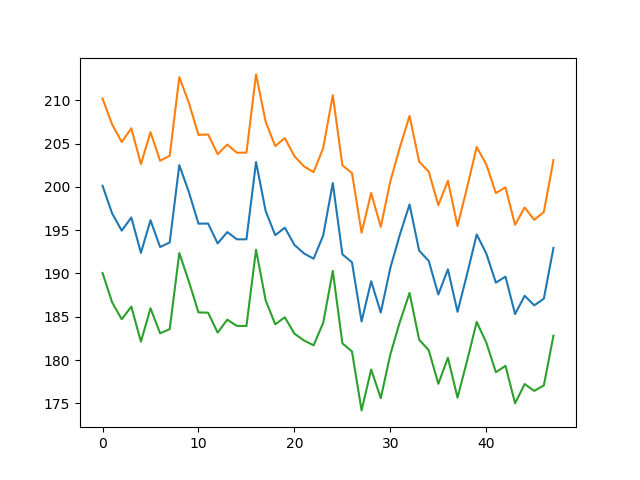

In [38]:
plt.figure()
plt.plot(trialrun[200:].mean(0))
plt.plot(trialrun[200:].mean(0)+trialrun.std(0)/np.sqrt(trialrun.shape[0]))
plt.plot(trialrun[200:].mean(0)-trialrun.std(0)/np.sqrt(trialrun.shape[0]))

<IPython.core.display.Javascript object>


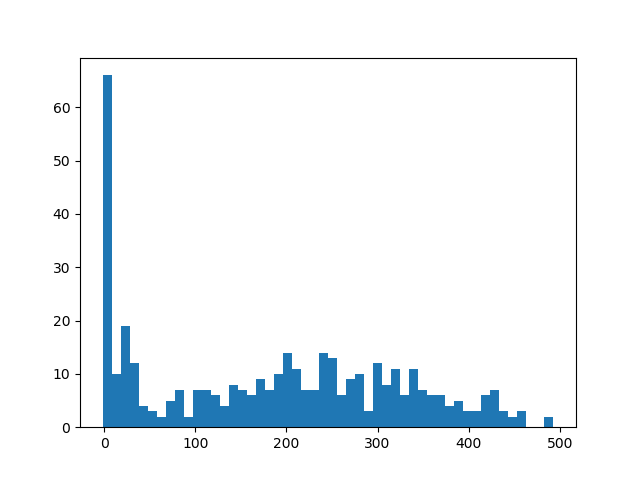

In [39]:
plt.figure()
plt.hist(trialrun.mean(1),50)
running = trialrun.mean(1)>100

In [41]:
pwd

'/home/mossing/Documents/notebooks/figure_ground'

In [42]:
def norm01(arr):
    return (arr-arr.min(1)[:,np.newaxis])/(arr.max(1)[:,np.newaxis]-arr.min(1)[:,np.newaxis])

In [43]:
order = ['ctrl','fig','grnd','iso','cross']
ori = stimparams[0]
sz = stimparams[1]
figContrast = stimparams[-2]
grndContrast = stimparams[-1]

paramdict = {}
paramdict['ctrl'] = np.logical_and(figContrast==0,grndContrast==0)
paramdict['fig'] = np.logical_and(figContrast==1,grndContrast==0)
paramdict['grnd'] = np.logical_and(np.logical_and(figContrast==0,grndContrast==1),sz>0)
paramdict['iso'] = sz==0
paramdict['cross'] = np.logical_and(figContrast==1,grndContrast==1)

In [44]:
def zscore(trialwise):
    arr = trialwise.reshape((trialwise.shape[0],trialwise.shape[1]*trialwise.shape[2]))
    arr = (arr-arr.mean(1)[:,np.newaxis])/arr.std(1)[:,np.newaxis]
    return arr.reshape(trialwise.shape)

In [45]:
strialwise.shape[-2]/nori/5

10.0

In [46]:
orilist = np.unique(ori)
nori = len(orilist)
# dimensions are cell X other fig/gd/etc. X orientation X rep no X time
# resp = np.zeros((zs.shape[0],5,nori,5,zs.shape[-1]))
resp = np.zeros((strialwise.shape[0],5,nori,int(strialwise.shape[-2]/nori/5),strialwise.shape[-1]))
running = np.zeros(resp.shape[1:-1]+trialrun.shape[-1:])
for i,name in enumerate(order):
    for j,angle in enumerate(orilist):
        resp[:,i,j,:,:] = zstrialwise[:,np.logical_and(ori==angle,paramdict[name]),:]
        running[i,j,:,:] = trialrun[np.logical_and(ori==angle,paramdict[name]),:]

In [47]:
def print_multipage(t,arr,fn,filename):
    from matplotlib.backends.backend_pdf import PdfPages
    plt.close()
    with PdfPages(filename+'.pdf') as pdf:
        for i in range(arr.shape[0]):
            fn(t,arr[i])
            pdf.savefig()
            plt.close()

In [48]:
t = np.arange(-extra_before,stimlen+extra_after)/(15.5/2)

NameError: name 'stimlen' is not defined

In [49]:
def fill_in_sem(t,arr,c='b'):
    mn = arr.mean(0)
    sem = arr.std(0)/np.sqrt(arr.shape[0])
    squiggle = plt.fill_between(t,mn-sem,mn+sem,facecolor=c,alpha=0.5)
    return squiggle

In [50]:
def plotZs(t,arr):
    for i in range(8):
        plt.subplot(3,4,i+1)
        ishift = np.remainder(i-2,8)
        squig_fig = fill_in_sem(t,arr[1,i],c='b')
        squig_ground = fill_in_sem(t,arr[2,ishift],c='g')
        squig_iso = fill_in_sem(t,arr[3,ishift],c='m')
        squig_cross = fill_in_sem(t,arr[4,i],c='c')
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
        plt.ylim((arr.mean(3).min()-arr.std(3).max(),arr.mean(3).max()+arr.std(3).max()))
    plt.subplot(3,4,12)
    plt.axis('off')
    plt.legend((squig_fig,squig_ground,squig_iso,squig_cross),('figure only','ground only','iso','cross'))

In [51]:
fig_responsive = (resp[:,1].mean(1).mean(1)-resp[:,1].mean(1).std(1)/np.sqrt(40)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
grnd_responsive = (resp[:,2].mean(1).mean(1)-resp[:,2].mean(1).std(1)/np.sqrt(40)).max(1)>(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)
lkat = np.logical_and(~fig_responsive,grnd_responsive) #~grnd_responsive)

In [52]:
grnd_responsive.sum()

74

In [53]:
resp[lkat].shape

(47, 5, 8, 10, 8)

<IPython.core.display.Javascript object>


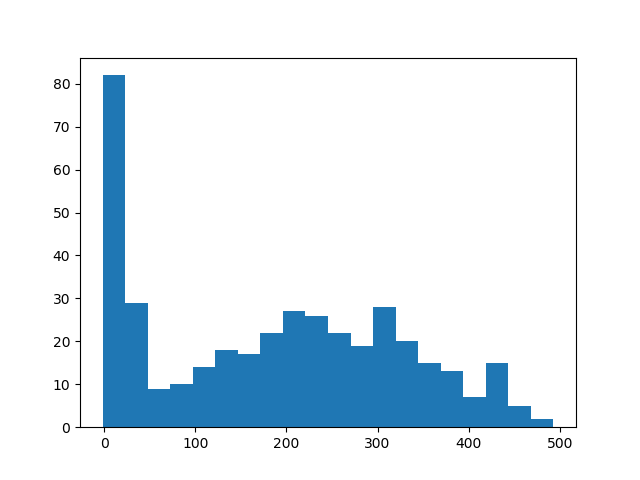

(array([ 82.,  29.,   9.,  10.,  14.,  18.,  17.,  22.,  27.,  26.,  22.,
         19.,  28.,  20.,  15.,  13.,   7.,  15.,   5.,   2.]),
 array([  -1.69392967,   23.04268805,   47.77930576,   72.51592348,
          97.2525412 ,  121.98915891,  146.72577663,  171.46239435,
         196.19901207,  220.93562978,  245.6722475 ,  270.40886522,
         295.14548293,  319.88210065,  344.61871837,  369.35533608,
         394.0919538 ,  418.82857152,  443.56518924,  468.30180695,
         493.03842467]),
 <a list of 20 Patch objects>)

In [54]:
plt.figure()
plt.hist(trialrun.mean(-1),20)

In [31]:
strialwise.shape

(202, 400, 4)

<IPython.core.display.Javascript object>


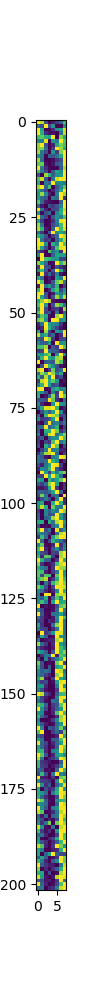

In [55]:
plt.figure(figsize=(1,10))
data = ut.norm01(strialwise[:,:300].mean(1))
pksort = np.argsort(np.argmax(data,axis=1))
data = ut.norm01(strialwise[:,300:].mean(1))
plt.imshow(data[pksort])

In [56]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

In [57]:
resp.shape

(202, 5, 8, 10, 8)

In [58]:
prefsort = np.argsort(np.argmax(resp[:,:,:,:,2:-3].mean(-1).mean(-1).mean(-1),axis=1))

In [59]:
preffed = np.argmax(resp[:,:,:,:,2:-3].mean(-1).mean(-1).mean(-1),axis=1)[prefsort]
border = np.where(np.diff(preffed))[0]

In [60]:
preffed

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [61]:
# resp[prefsort][12][1][:,:,8:-15].mean(-1.shape

<IPython.core.display.Javascript object>


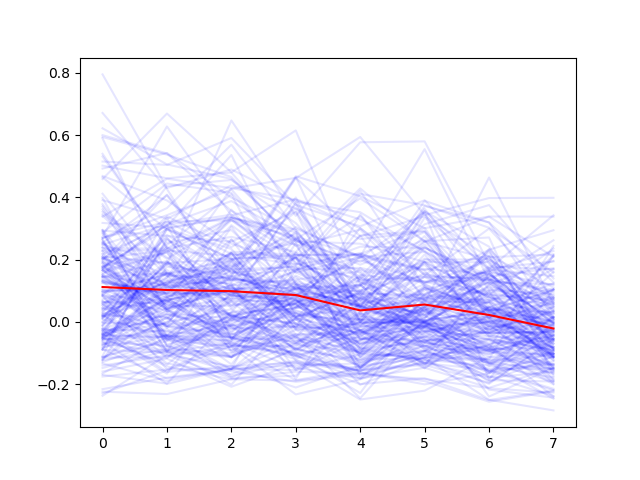

In [62]:
plt.figure()
plt.plot(resp[:,0,:,:,:].mean(-2).mean(-2).T,alpha=0.1,c='b')
plt.plot(resp[:,0,:,:,:].mean(0).mean(-2).mean(-2),c='r')

In [63]:
np.nanmean(ret[prefsort][preffed==i],axis=0).shape

(5, 7, 2)

<IPython.core.display.Javascript object>


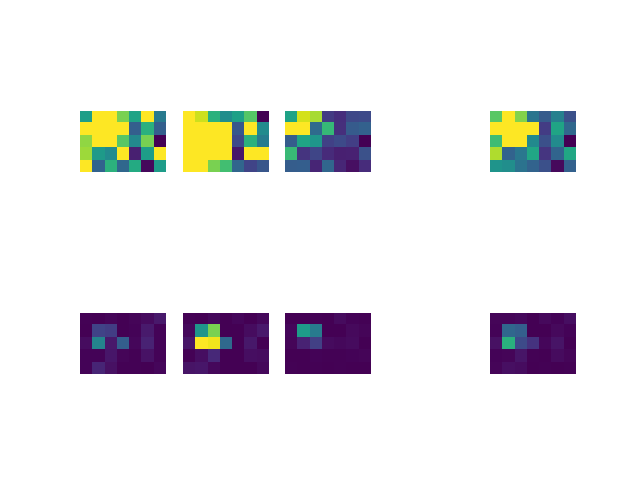

In [64]:
plt.figure()
for i in range(5):
    plt.subplot(2,5,i+1)
    if np.sum(preffed==i):
        plt.imshow(np.nanmean(ret[prefsort][preffed==i],axis=0)[:,:,0],vmax=np.nanmax(ret)/10)
    plt.axis('off')
    plt.subplot(2,5,5+i+1)
    if np.sum(preffed==i):
        plt.imshow(np.nanmean(ret[prefsort][preffed==i],axis=0)[:,:,1],vmax=np.nanmax(ret)/10)
    plt.axis('off')

In [65]:
(preffed==2).sum()

13

<IPython.core.display.Javascript object>


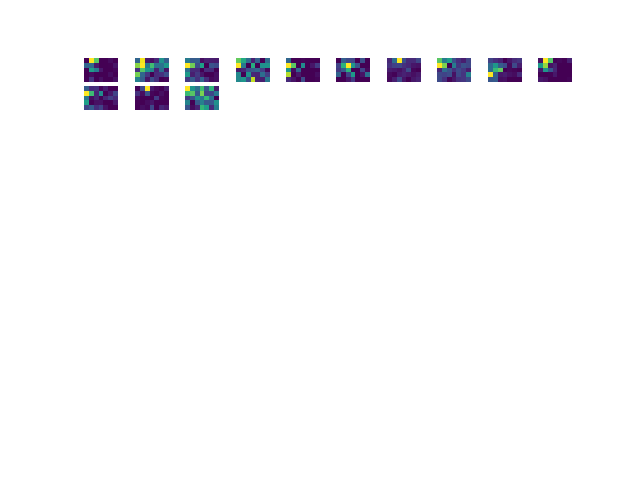

In [66]:
plt.figure()
for j in range((preffed==2).sum()):
    plt.subplot(13,10,j+1)
    if np.isnan(ret[prefsort][preffed==2][j][:,:,0]).sum():
        print("couldn't do "+str(j))
        plt.axis('off')
    else:
        plt.imshow(ret[prefsort][preffed==2][j][:,:,0])
        plt.axis('off')
        

<IPython.core.display.Javascript object>


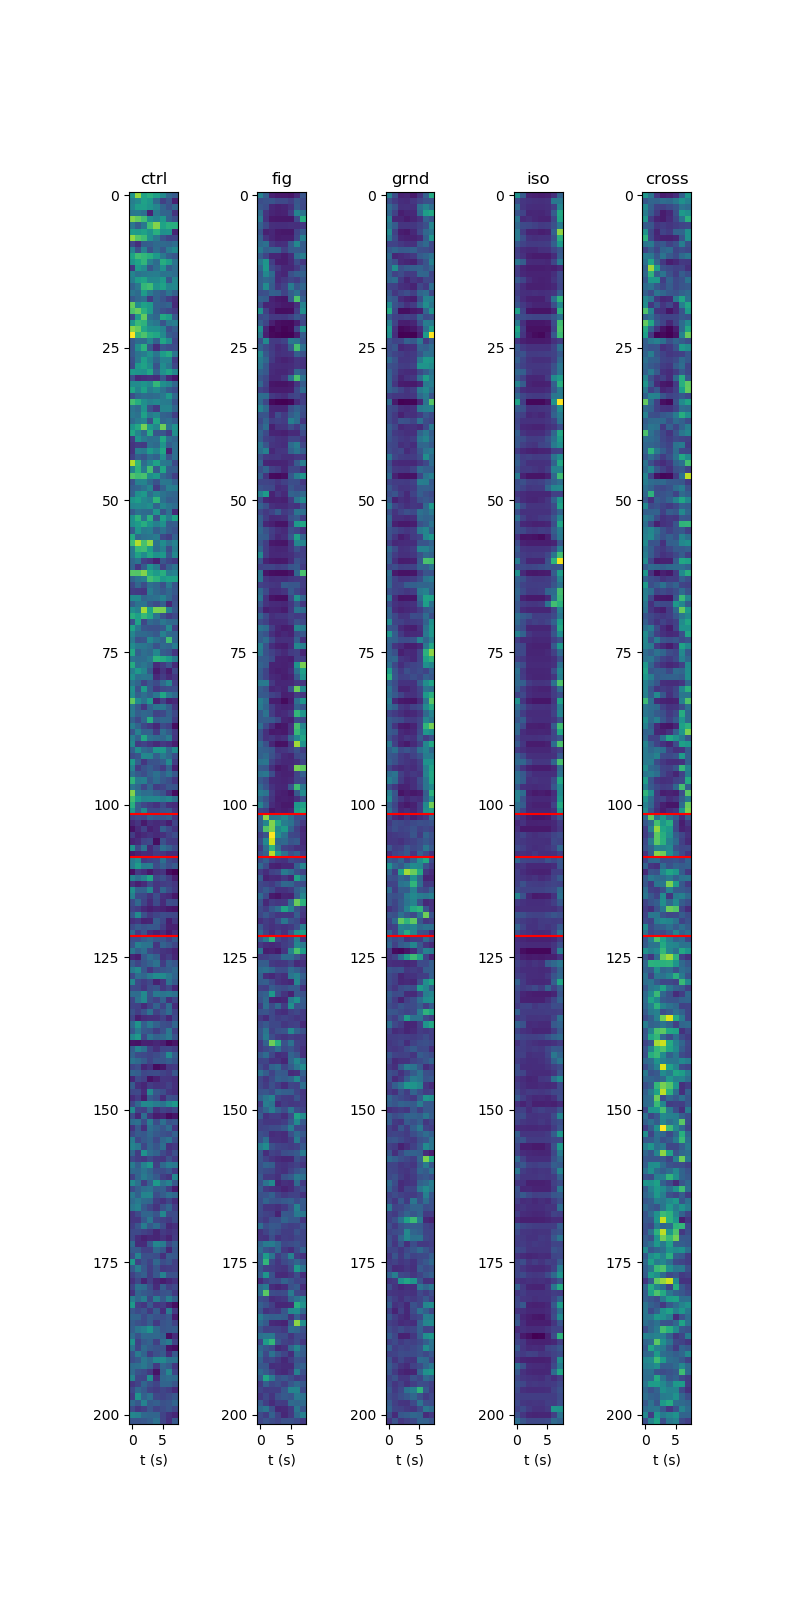

In [67]:
plt.figure(figsize=(8,16))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.imshow(resp[prefsort][:,k].mean(1).mean(1))#,vmin=0,vmax=resp.mean(1).mean(1).mean(1).mean(1).max())
    for j in range(len(border)):
        plt.plot((-0.5,7.5),(border[j]+0.5,border[j]+0.5),c='r')
#     plt.xticks((0,7.75,15.5),(0,1,2))
    plt.title(order[k])
    plt.xlabel('t (s)')

In [68]:
data.shape

(202, 8)

In [69]:
prefsort

array([  0, 138, 137, 135, 133, 132, 130, 127, 126, 124, 123, 122, 118,
       114, 112, 111, 110, 108,  79,  84,  86,  90,  91,  92, 140,  93,
        96,  98, 200, 104, 105, 107,  94, 141, 146, 149, 176, 179, 181,
       185, 186, 187, 174, 189, 191, 192, 195, 196, 197, 199, 190,  75,
       173, 171, 150, 153, 154, 155, 157, 158, 172, 160, 164, 165, 166,
       167, 168, 170, 163,  70, 100,  18,  63,  62,  51,  60,  59,  24,
        58,  12,  57,  43,  13,  44,  55,  14,  22,  53,  41,  64,  50,
         9,  39,   8,   1,   6,   5,  49,  26,   4,   3,   2, 147,  47,
        87,  27,  42,  38,  15, 120,  16,  48, 156,  30, 144,  23, 162,
        33,  72, 113,  74, 177,  17, 151, 152,  31, 198,  29, 194,  28,
       193,   7, 159, 188, 161,  19,  11, 184, 183,  25, 182, 180, 178,
       175,  21,  32,  20, 169,  10,  71, 136,  34, 103, 102, 101,  99,
        97,  95,  61,  89,  88,  65,  56,  85,  83,  82,  81,  80,  67,
        78,  77,  76,  68,  73,  66, 148, 106, 109, 145, 143, 14

<IPython.core.display.Javascript object>


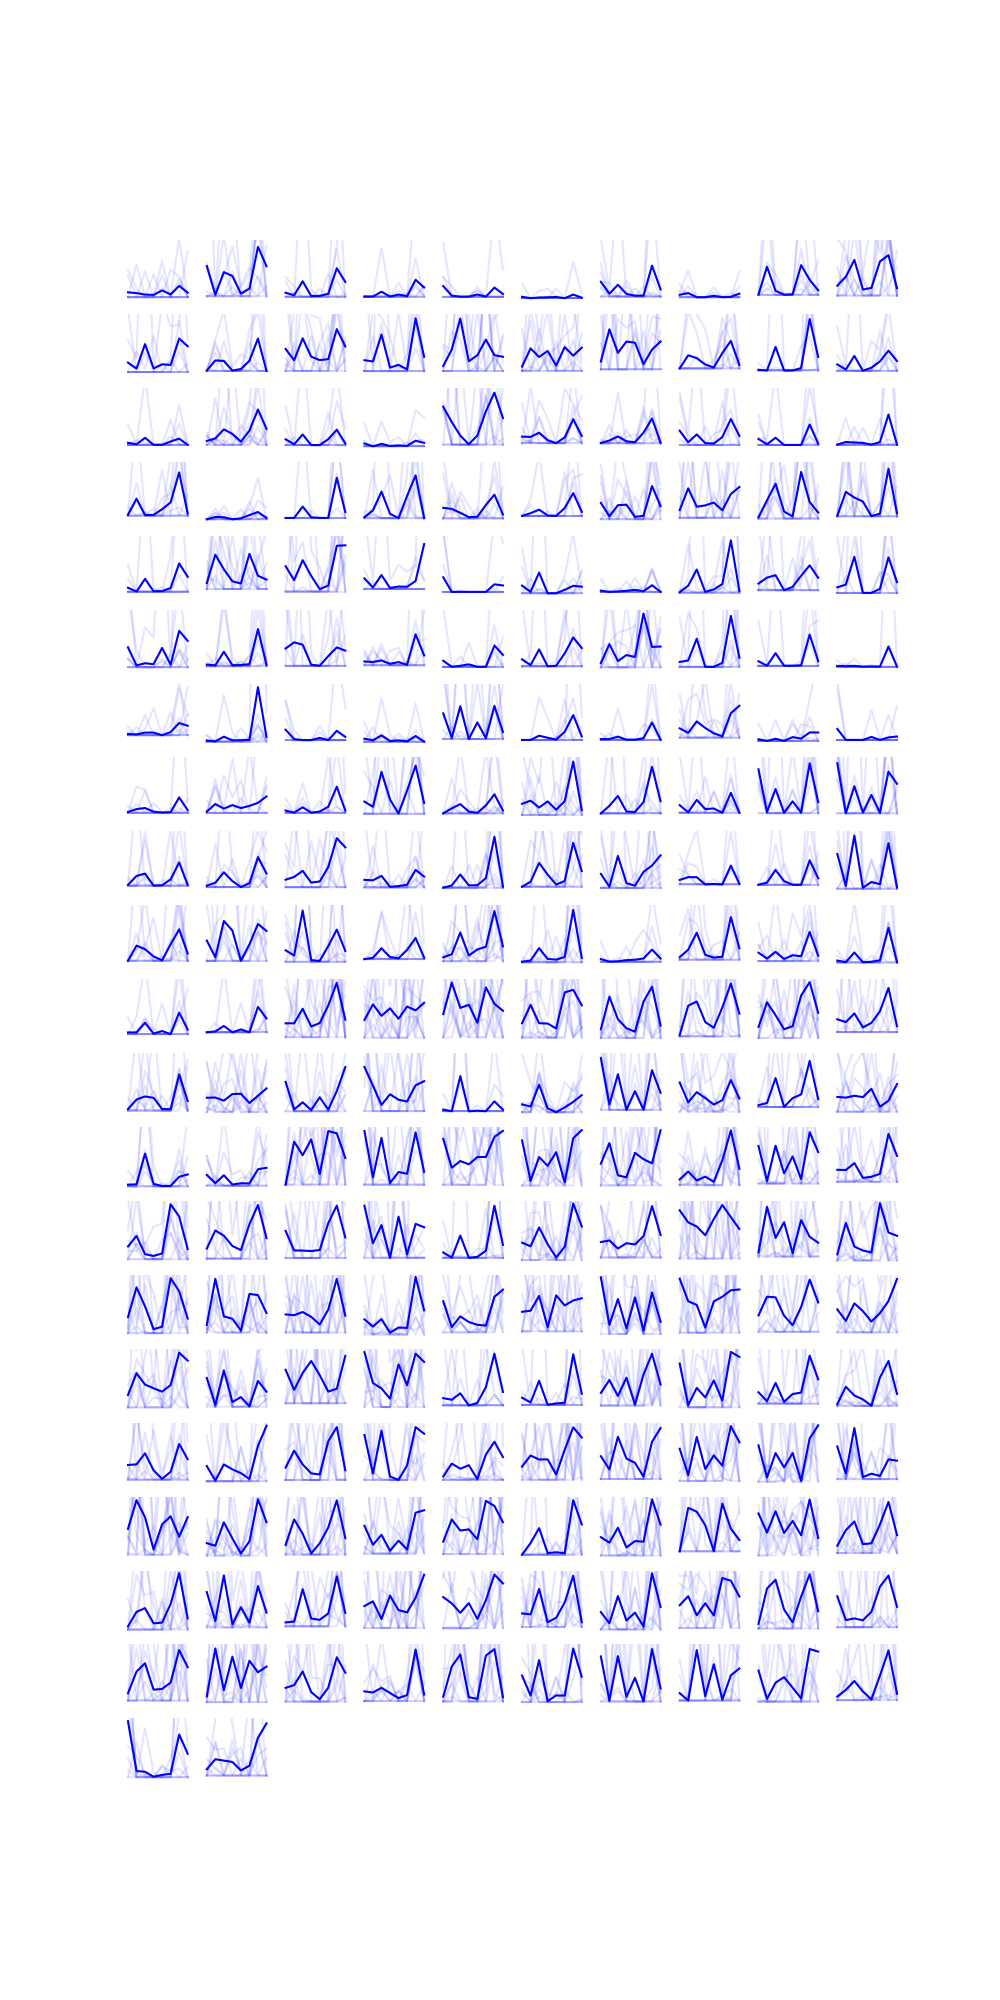

In [70]:
plt.figure(figsize=(10,20))
for k in range(resp.shape[0]):
    plt.subplot(21,10,k+1)
    data = resp[prefsort[k],:,:,:,2:-3].mean(-1)
    plt.plot(data[-1],c='b',alpha=0.1)
    plt.plot(data[-1].mean(-1),c='b')
    plt.ylim(data.mean(-1).min()-0.1,data.mean(-1).max()+0.1)
    plt.axis('off')

In [71]:
data[-1]

array([[-0.20293828, -0.20293828, -0.04870482,  0.12870619, -0.20293828,
        -0.20293828,  0.55662394, -0.20293828, -0.20293828, -0.20293828],
       [ 0.90183459,  0.46466753, -0.20293828, -0.05521677,  0.48019313,
        -0.20293828,  0.30918697, -0.05178287, -0.20293828, -0.20293828],
       [ 2.24645323, -0.20293828, -0.20293828, -0.20293828, -0.20293828,
        -0.20293828,  0.34068848, -0.20293828, -0.20293828, -0.20293828],
       [ 0.82723667,  0.51124318, -0.20293828, -0.20293828, -0.20293828,
        -0.20293828, -0.20293828,  0.34278871,  0.22740094, -0.20293828],
       [-0.20293828, -0.20293828,  0.13848   , -0.20293828, -0.20293828,
        -0.20293828, -0.20293828, -0.07777955,  0.35152829, -0.20293828],
       [-0.20293828, -0.20293828, -0.20293828, -0.20293828, -0.20293828,
         1.44853705,  0.1118499 , -0.20293828, -0.20293828, -0.20293828],
       [ 3.08168823,  0.63697819,  2.11628655,  0.19817965, -0.20293828,
        -0.20293828, -0.20293828, -0.20293828

In [72]:
resptavg = resp[:,:].mean(2).mean(2).mean(-1)

In [73]:
resp.shape

(202, 5, 8, 10, 8)

In [77]:
matdict = {}
matdict['dataX'] = resptavg[:,-2]
matdict['dataY'] = resptavg[:,-1]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate iso-oriented'
matdict['labelY'] = 'z-scored event rate cross-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('vip_iso_cross_180528.mat',matdict)

In [78]:
matdict = {}
matdict['dataX'] = resptavg[:,1]
matdict['dataY'] = resptavg[:,3]
# matdict['leg'] = [str(int(round(x)))+' deg.' for x in usize]
# matdict['data'] = mn_lkat
matdict['labelX'] = 'z-scored event rate center only'
matdict['labelY'] = 'z-scored event rate iso-oriented'
# matdict['x'] = 100*ucontrast
sio.savemat('vip_center_iso_180528.mat',matdict)

<IPython.core.display.Javascript object>


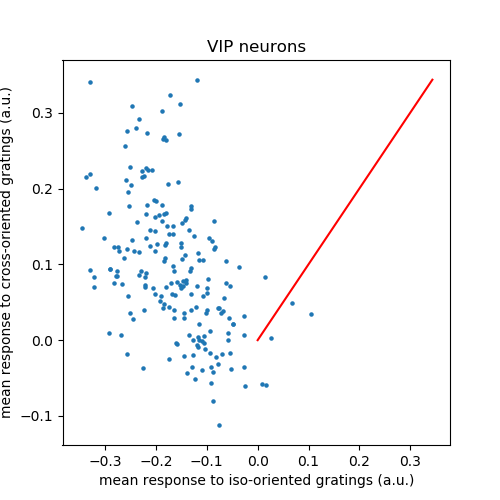

Text(0.5,1,'VIP neurons')

In [79]:
plt.figure(figsize=(5,5))
plt.scatter(resptavg[:,-2],resptavg[:,-1],s=5)
mxm = np.maximum(resptavg[:,-2].max(),resptavg[:,-1].max())
plt.plot((0,mxm),(0,mxm),c='r')
# plt.xlim((0,mxm))
# plt.ylim((0,mxm))
plt.xlabel('mean response to iso-oriented gratings (a.u.)')
plt.ylabel('mean response to cross-oriented gratings (a.u.)')
plt.title('VIP neurons')
# plt.savefig('vip_iso_cross.eps')

<IPython.core.display.Javascript object>


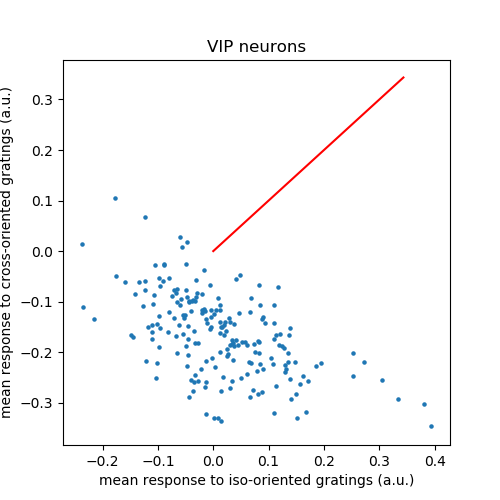

Text(0.5,1,'VIP neurons')

In [80]:
plt.figure(figsize=(5,5))
plt.scatter(resptavg[:,1],resptavg[:,3],s=5)
mxm = np.maximum(resptavg[:,-2].max(),resptavg[:,-1].max())
plt.plot((0,mxm),(0,mxm),c='r')
# plt.xlim((0,mxm))
# plt.ylim((0,mxm))
plt.xlabel('mean response to iso-oriented gratings (a.u.)')
plt.ylabel('mean response to cross-oriented gratings (a.u.)')
plt.title('VIP neurons')

<IPython.core.display.Javascript object>


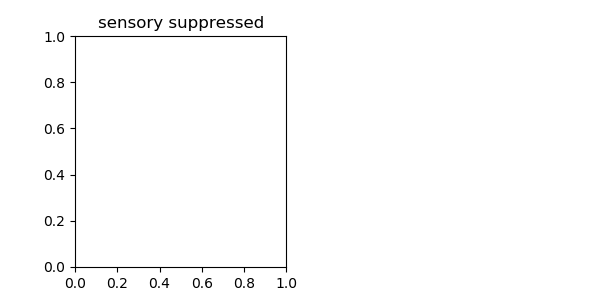

ValueError: x and y must have same first dimension, but have shapes (18,) and (0, 5)

In [81]:
t = np.arange(-2,16)/7.75
plt.figure(figsize=(6,3))
# plt.hspace(10)
plt.subplot(1,2,1)
plt.title('sensory suppressed')
plt.plot(t,resp[prefsort][preffed==0].mean(0).mean(-2).mean(-2).T[6:-7])
plt.fill_between((0,1),(0.015,0.015),(0.11,0.11),alpha=0.1,color='k')
plt.xlabel('t (s)')
plt.ylabel('event rate (a.u.)')
plt.subplot(1,2,2)
plt.title('ground tuned')
plt.plot(t,resp[prefsort][preffed==2].mean(0).mean(-2).mean(-2).T[6:-7])
plt.fill_between((0,1),(0.015,0.015),(0.2,0.2),alpha=0.1,color='k')
plt.legend(order,loc='upper right')
plt.tight_layout()

In [262]:
(preffed>-1).sum()

365

These are "spike rates" deconvolved using OASIS. In these data, the stimuli were delivered between 0 and 1 second. "Ctrl" refers to catch trials, in which the screen remained gray during the stim delivery. From these plots, the following observations are made: 

1. A subset of VIP neurons (67/365) are spontaneously active and suppressed by all the sensory stimuli shown.

2. 

<IPython.core.display.Javascript object>


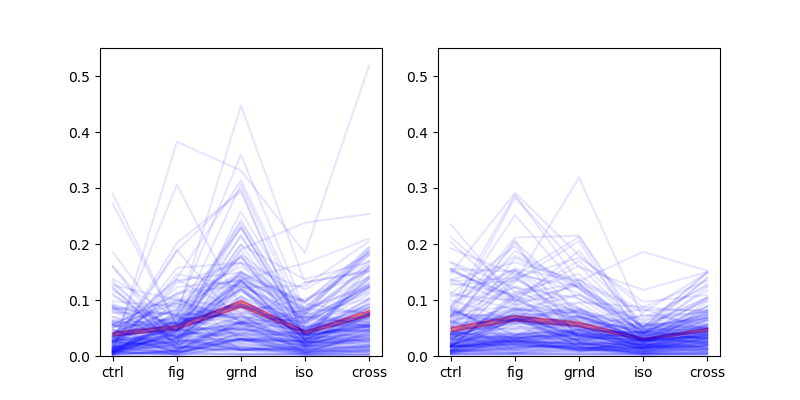

([<matplotlib.axis.XTick at 0x7fbcbda43be0>,
 <a list of 5 Text xticklabel objects>)

In [209]:
plt.figure(figsize=(8,4))
summary_onset = resp[:,:,:,:,8:-15].mean(-1).mean(-1).mean(-1)
lb_onset,ub_onset = ut.bootstrap(summary_onset,np.mean,pct=(16,84))
summary_offset = resp[:,:,:,:,-15:-8].mean(-1).mean(-1).mean(-1)
lb_offset,ub_offset = ut.bootstrap(summary_offset,np.mean,pct=(16,84))
plt.subplot(1,2,1)
plt.plot(summary_onset.T,c='b',alpha=0.1)
plt.fill_between((0,1,2,3,4),lb_onset,ub_onset,color='r',alpha=0.5)
plt.ylim((0,0.55))
plt.xticks((0,1,2,3,4),order)
plt.subplot(1,2,2)
plt.plot(summary_offset.T,c='b',alpha=0.1)
plt.fill_between((0,1,2,3,4),lb_offset,ub_offset,color='r',alpha=0.5)
plt.ylim((0,0.55))
plt.xticks((0,1,2,3,4),order)

<IPython.core.display.Javascript object>


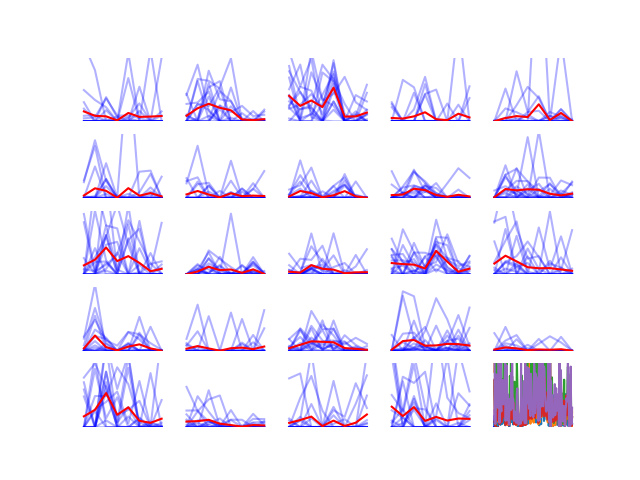

In [148]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][3,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][3,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][3].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


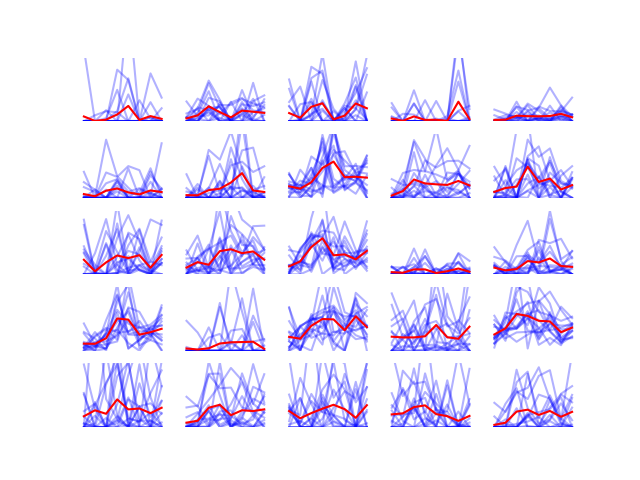

In [145]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][1,:,:,8:-15].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][1].mean(1).max())
    plt.axis('off')

In [ ]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][i][1].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][i][1].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][i][1].mean(-1).mean(1).max()+0.1)
    plt.axis('off')

In [134]:
resp[0][1].shape

(8, 15, 31)

In [ ]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


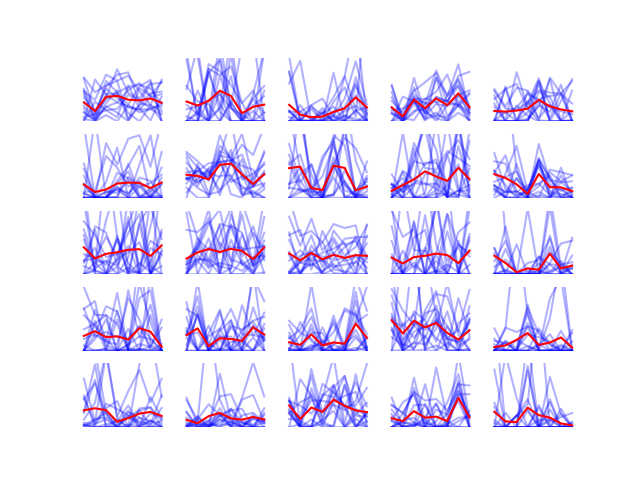

In [141]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,-15:-8].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


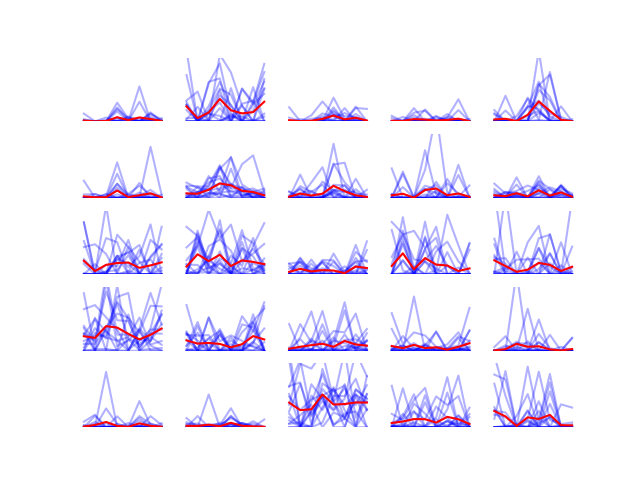

In [142]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.plot(resp[pksort][140+i][1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[pksort][140+i][1,:,:,8:-15].mean(-1).mean(1),c='r')
    plt.ylim(0,resp[pksort][140+i][1].mean(1).max())
    plt.axis('off')

<IPython.core.display.Javascript object>


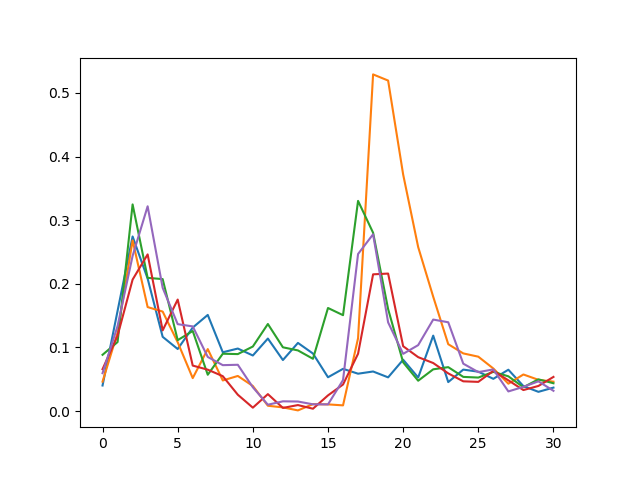

In [96]:
plt.figure()
plt.plot(resp[pksort][140].mean(1).mean(1).T)

<IPython.core.display.Javascript object>


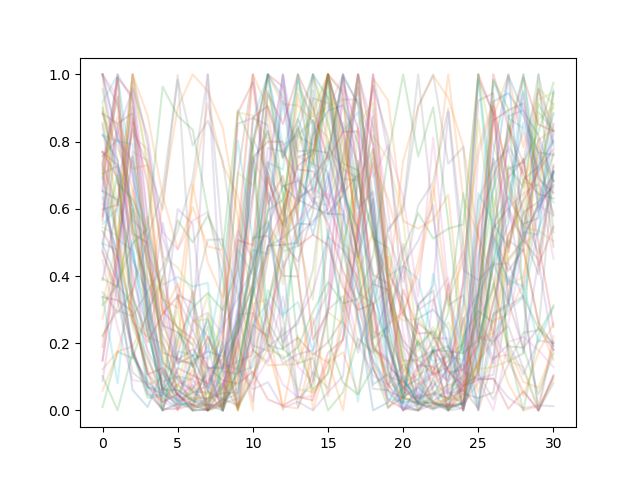

In [46]:
plt.figure()
plt.plot(ut.norm01(s.mean(1)).T,alpha=0.2)

<IPython.core.display.Javascript object>


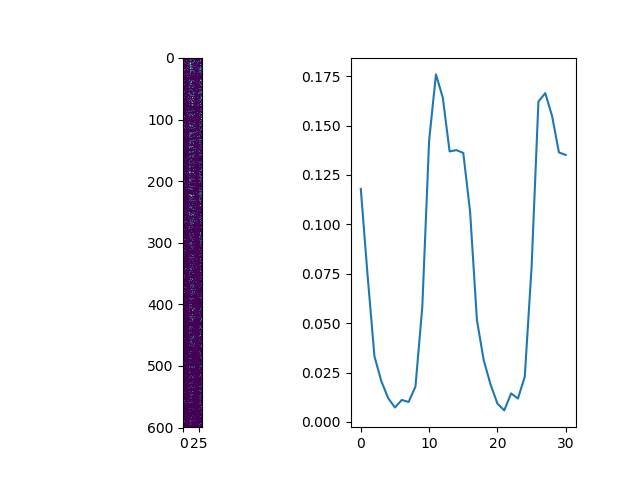

In [39]:
k = 0
plt.figure()
plt.subplot(1,2,1)
plt.imshow(s[k])
plt.subplot(1,2,2)
plt.plot(s[k].mean(0))

<IPython.core.display.Javascript object>


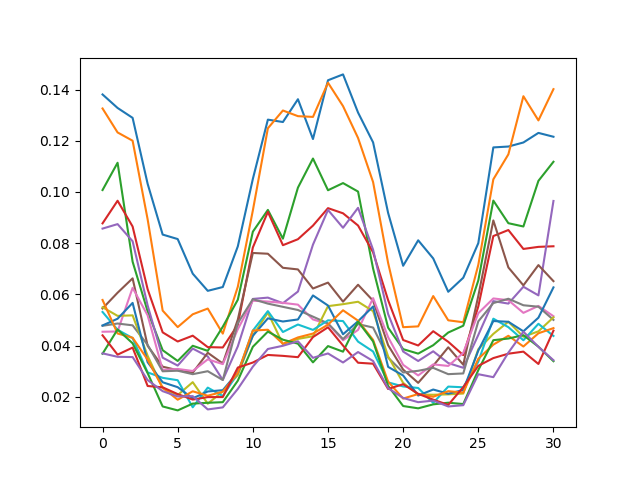

In [232]:
plt.figure()
plt.plot(resp.mean(0).mean(0).mean(0).T)

<IPython.core.display.Javascript object>


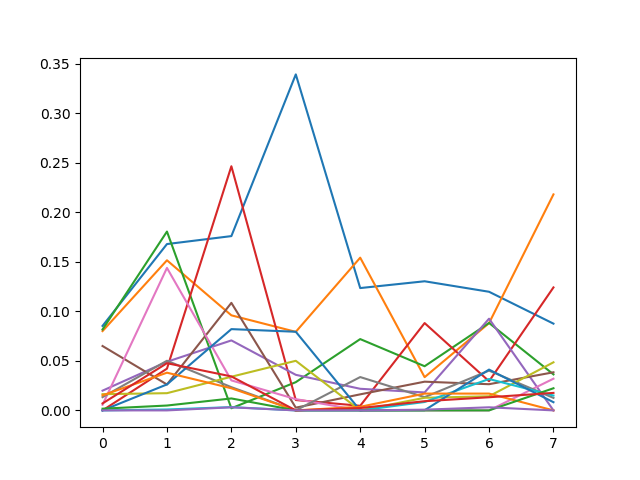

In [233]:
# plt.plot(resp[27,2].mean(-1))
# plt.plot(resp[2,2].mean(-1))
plt.plot(resp[33,3].mean(-1))

<IPython.core.display.Javascript object>


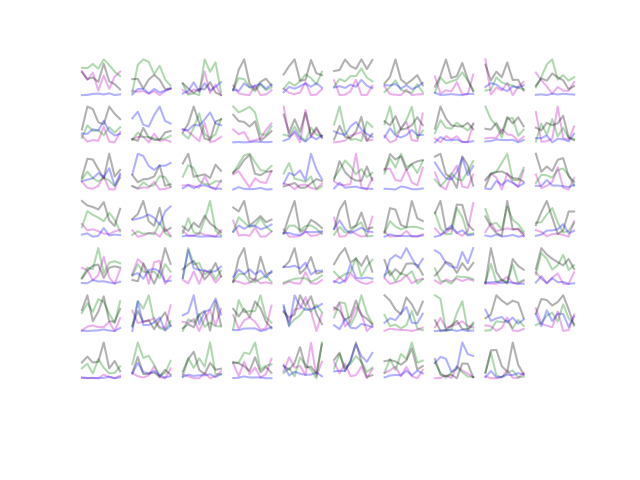

In [244]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1).mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

<IPython.core.display.Javascript object>


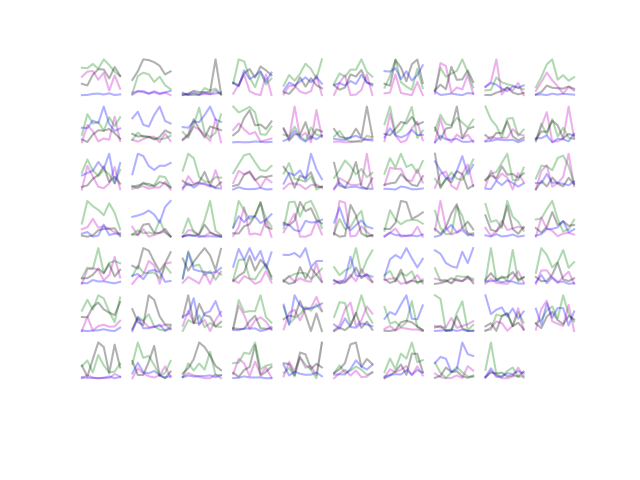

In [243]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,8:-15].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

In [235]:
order

['ctrl', 'fig', 'grnd', 'iso', 'cross']

<IPython.core.display.Javascript object>


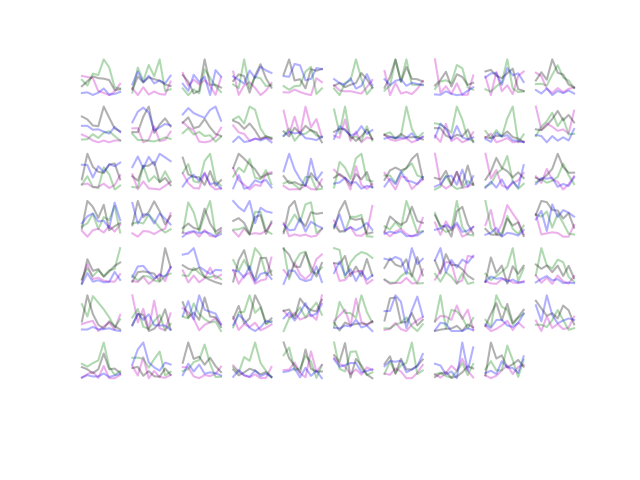

In [245]:
plt.figure()#(figsize=(12,10))
lkat = np.ones((resp.shape[0],),dtype=bool)
for i in range(lkat.sum()):
    plt.subplot(8,10,i+1)
    # magenta: iso, green: cross, black: grnd
#     plt.plot(resp[lkat][i,1,:,:,4:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,-15:-8].mean(-1).mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='k')
    plt.plot(resp[lkat][i,0,:,:,-15:-8].mean(-1).mean(-1),alpha=0.3,c='b')
    plt.axis('off')

<IPython.core.display.Javascript object>


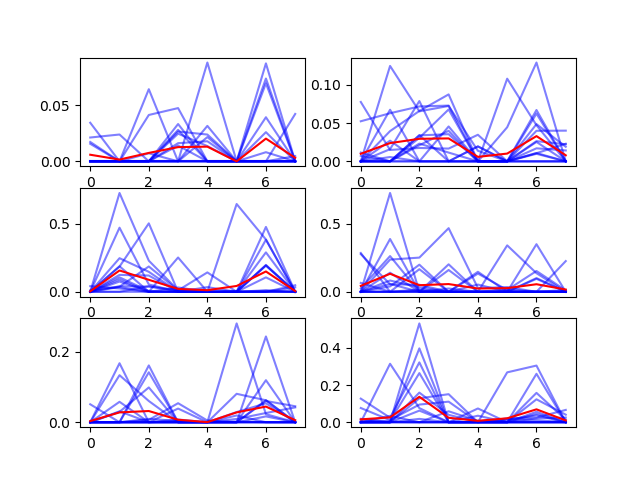

In [239]:
plt.figure()
K = 11
plt.subplot(3,2,1)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,2)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 20
plt.subplot(3,2,3)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,4)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 27
plt.subplot(3,2,5)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,6)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')

<IPython.core.display.Javascript object>


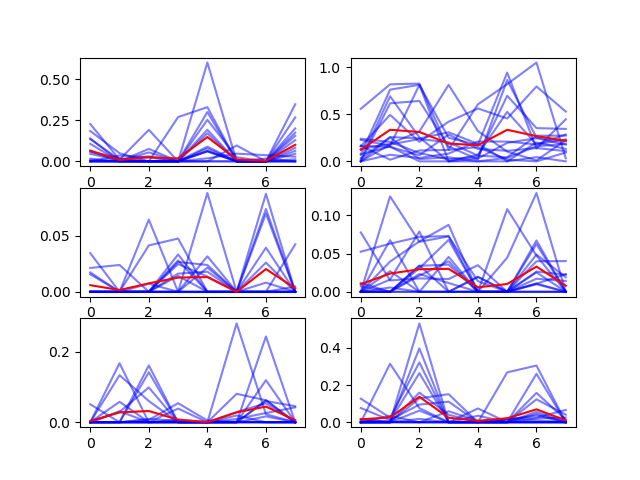

In [241]:
plt.figure()
K = 10
plt.subplot(3,2,1)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))],alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1)[np.concatenate((np.arange(2,8),np.arange(0,2)))].mean(-1),c='r')
plt.subplot(3,2,2)
plt.plot(resp[lkat][K,2,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,2,:,:,8:-15].mean(-1).mean(-1),c='r')
K = 11
plt.subplot(3,2,3)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,4)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')
K = 27
plt.subplot(3,2,5)
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,8:-15].mean(-1).mean(-1),c='r')
plt.subplot(3,2,6)
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1),alpha=0.5,c='b')
plt.plot(resp[lkat][K,3,:,:,-15:-8].mean(-1).mean(-1),c='r')

<IPython.core.display.Javascript object>


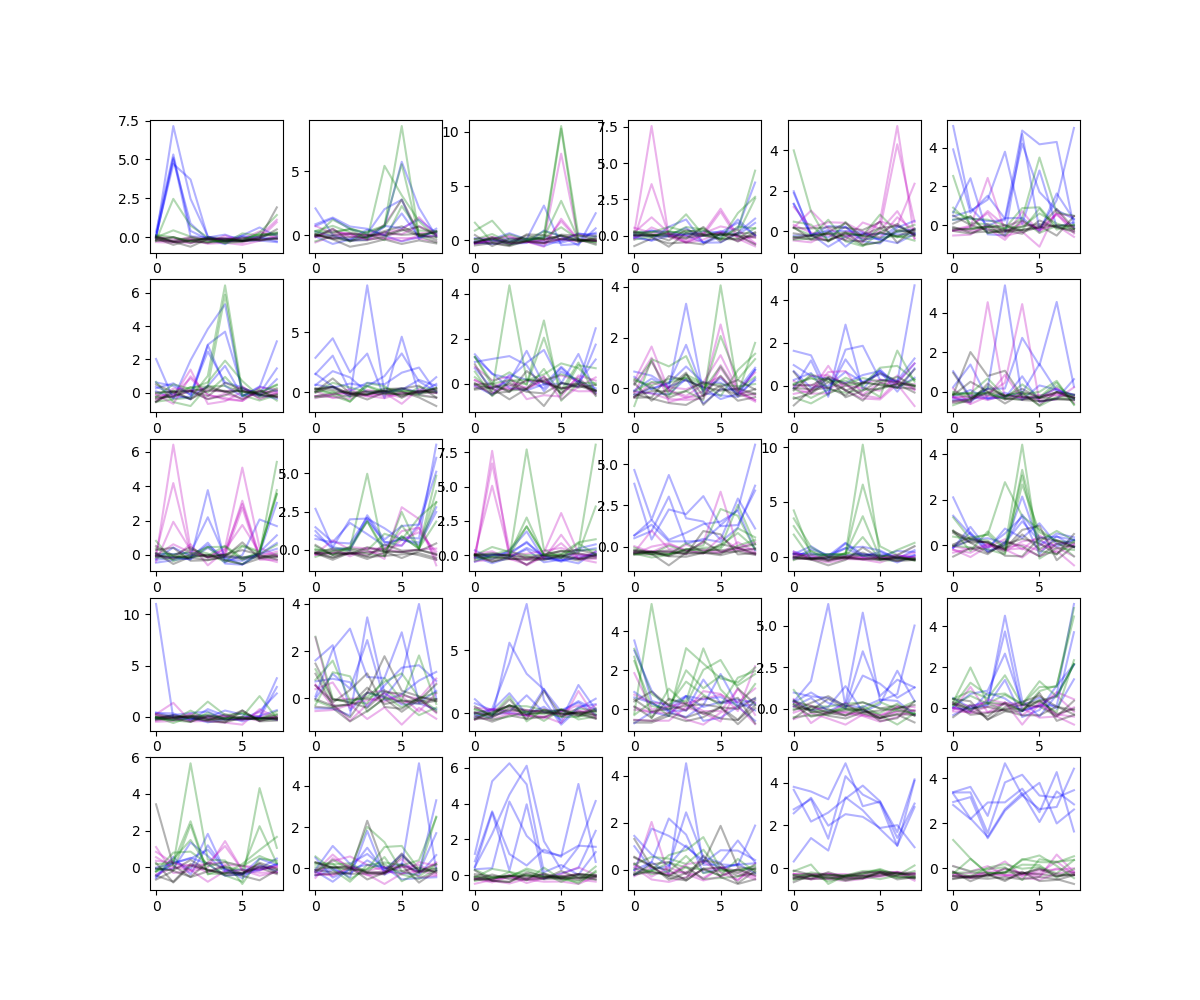

In [87]:
plt.figure(figsize=(12,10))
for i in range(lkat.sum()):
    plt.subplot(5,6,i+1)
    plt.plot(resp[lkat][i,1,:,:,8:-15].mean(-1),alpha=0.3,c='b')
    plt.plot(resp[lkat][i,3,:,:,8:-15].mean(-1),alpha=0.3,c='m')
    plt.plot(resp[lkat][i,4,:,:,8:-15].mean(-1),alpha=0.3,c='g')
    plt.plot(resp[lkat][i,2,:,:,8:-15].mean(-1),alpha=0.3,c='k')

<IPython.core.display.Javascript object>


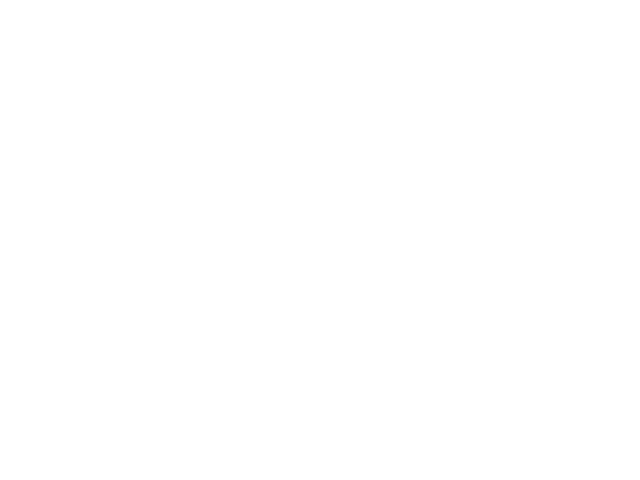

<IPython.core.display.Javascript object>


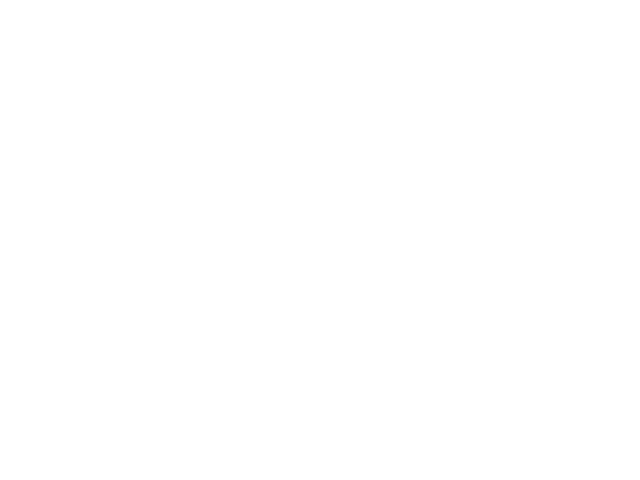

<IPython.core.display.Javascript object>


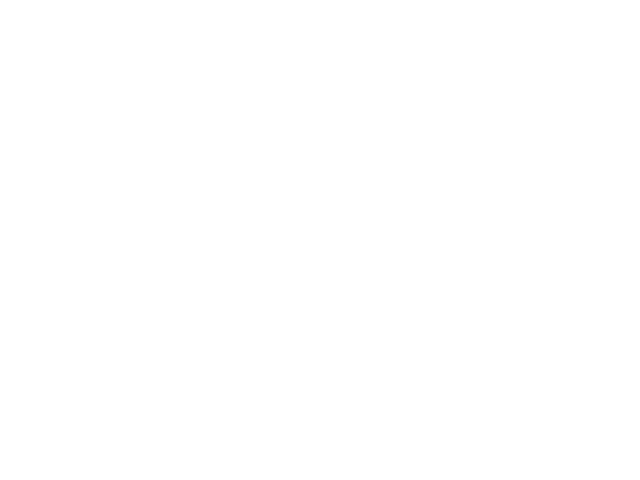

<IPython.core.display.Javascript object>


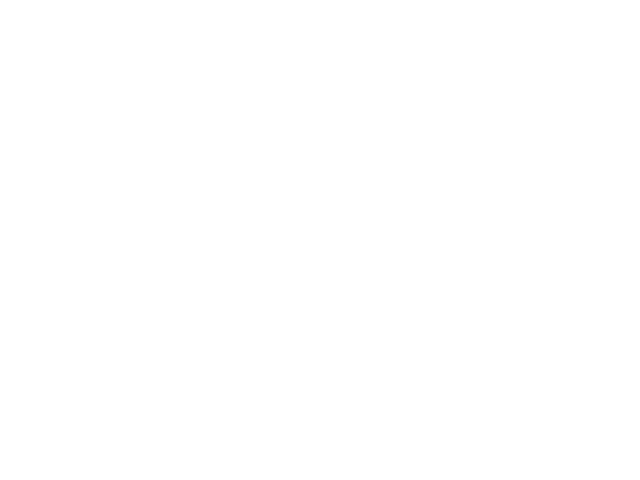

<IPython.core.display.Javascript object>


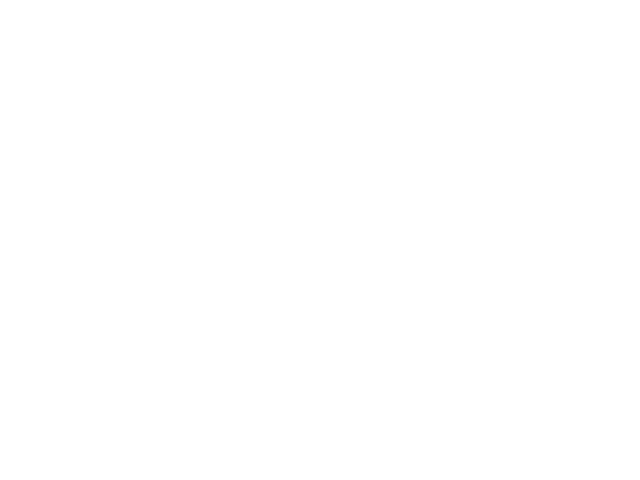

<IPython.core.display.Javascript object>


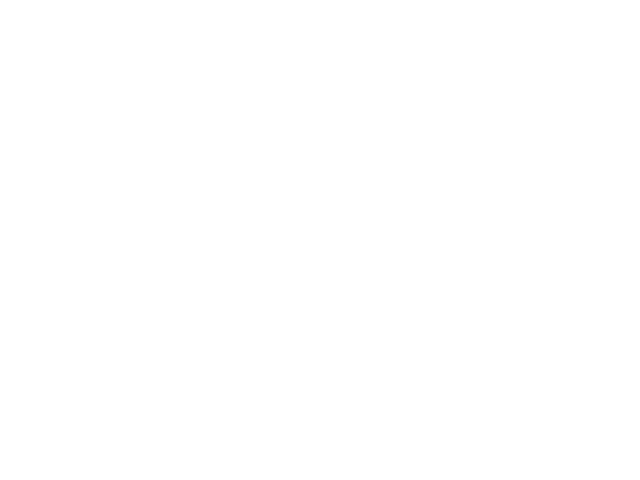

<IPython.core.display.Javascript object>


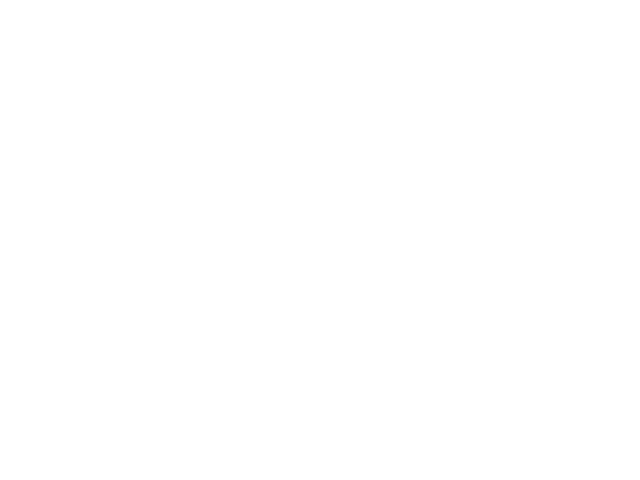

<IPython.core.display.Javascript object>


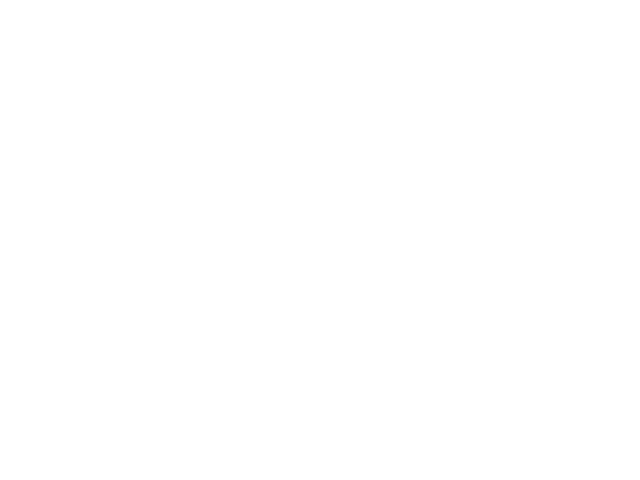

<IPython.core.display.Javascript object>


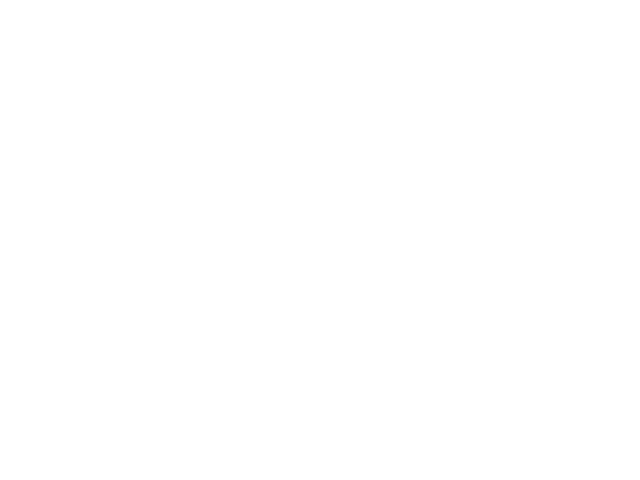

<IPython.core.display.Javascript object>


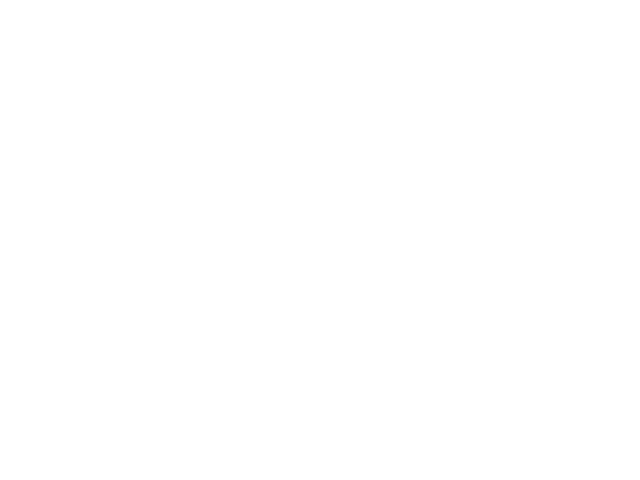

<IPython.core.display.Javascript object>


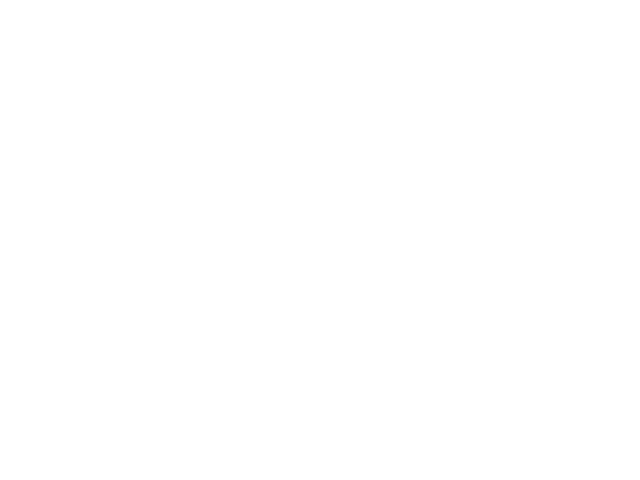

<IPython.core.display.Javascript object>


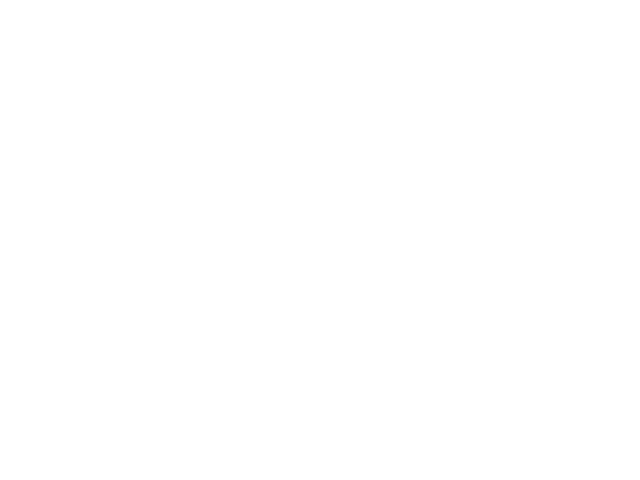

<IPython.core.display.Javascript object>


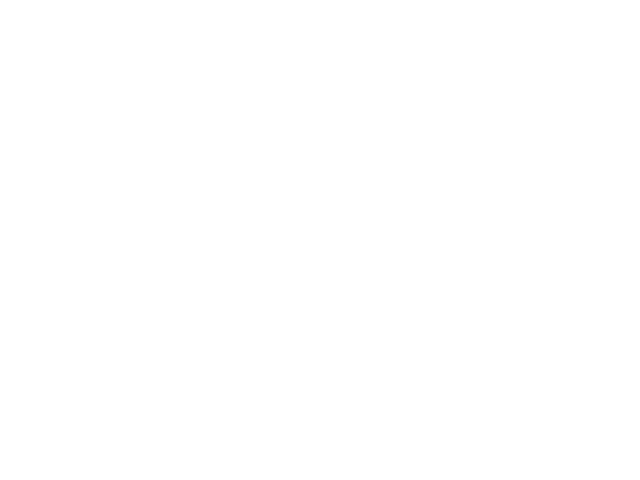

<IPython.core.display.Javascript object>


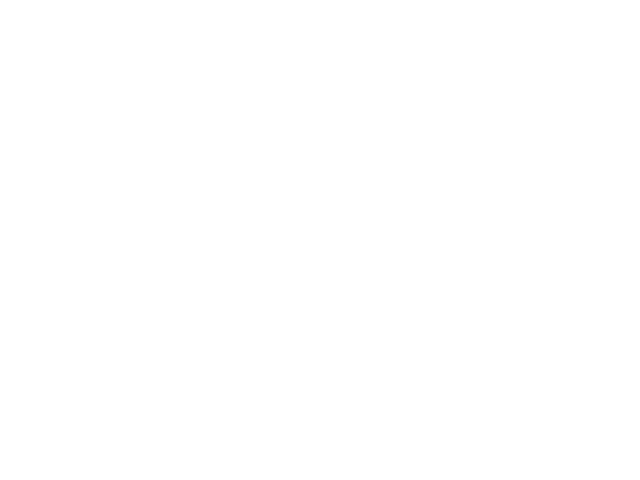

<IPython.core.display.Javascript object>


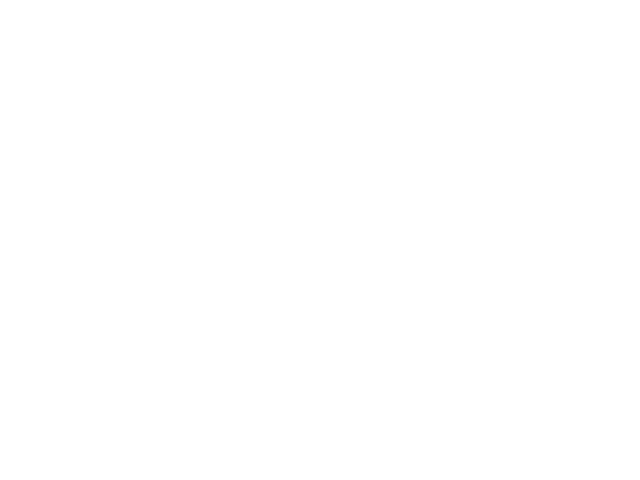

<IPython.core.display.Javascript object>


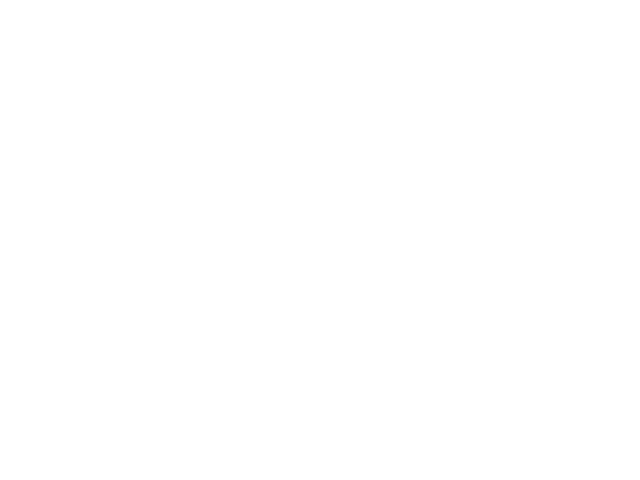

<IPython.core.display.Javascript object>


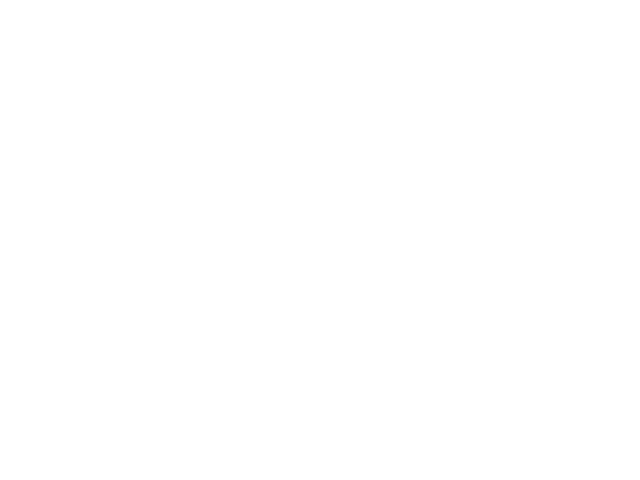

<IPython.core.display.Javascript object>


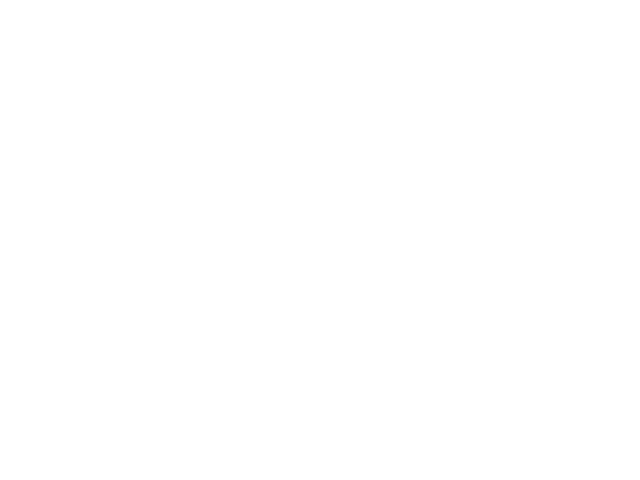

<IPython.core.display.Javascript object>


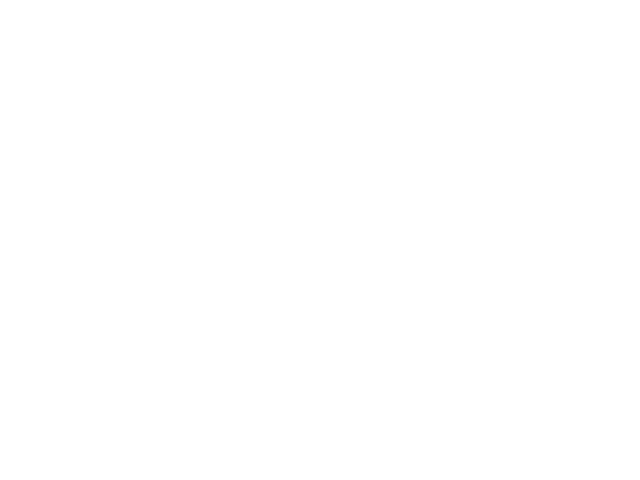

<IPython.core.display.Javascript object>


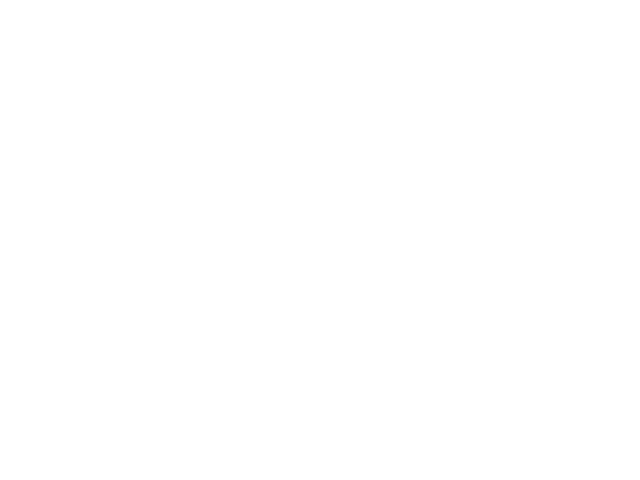

<IPython.core.display.Javascript object>


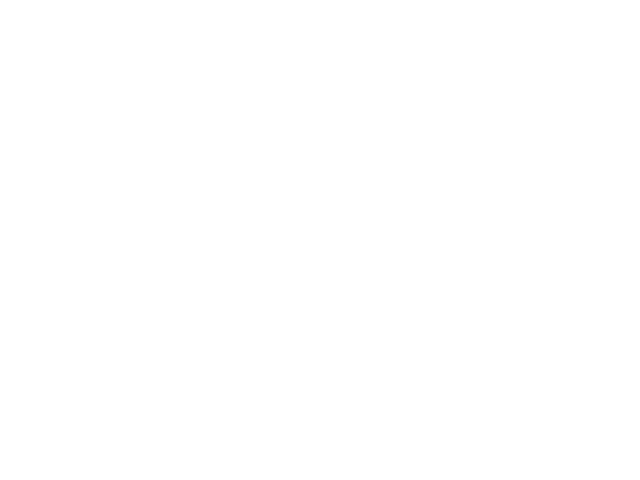

<IPython.core.display.Javascript object>


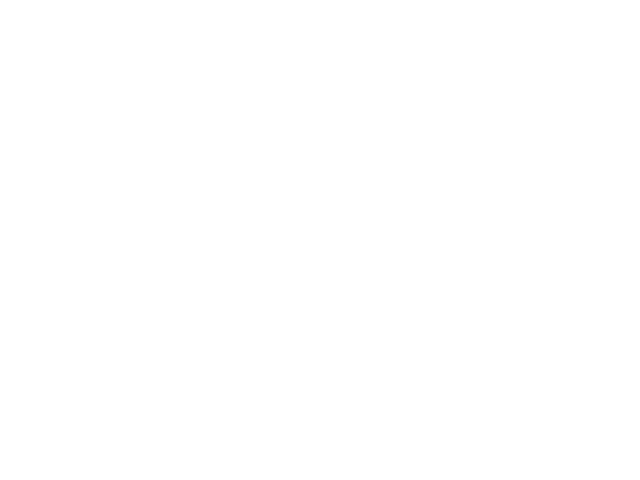

<IPython.core.display.Javascript object>


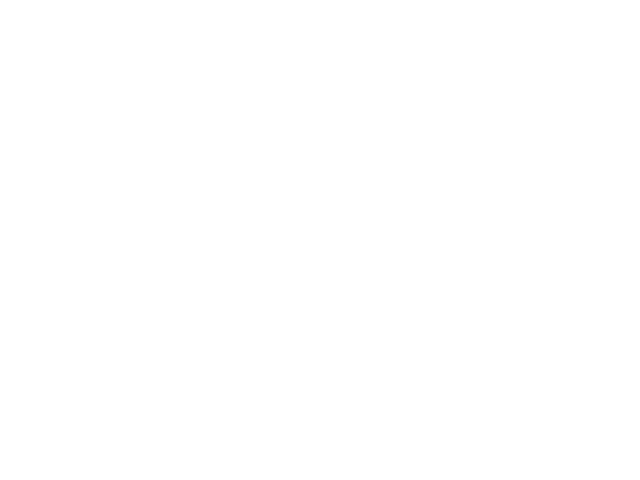

<IPython.core.display.Javascript object>


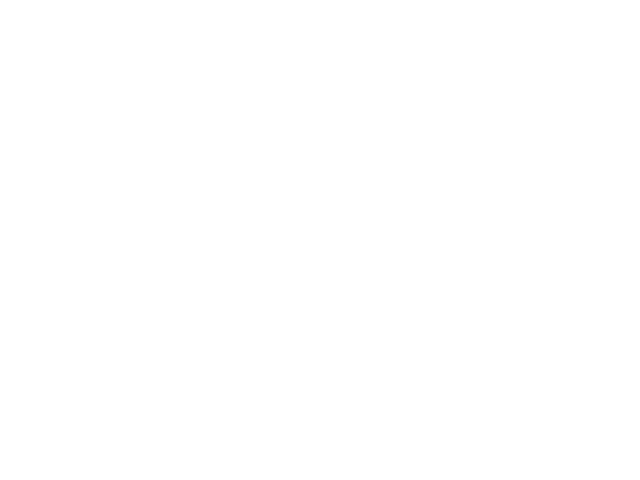

<IPython.core.display.Javascript object>


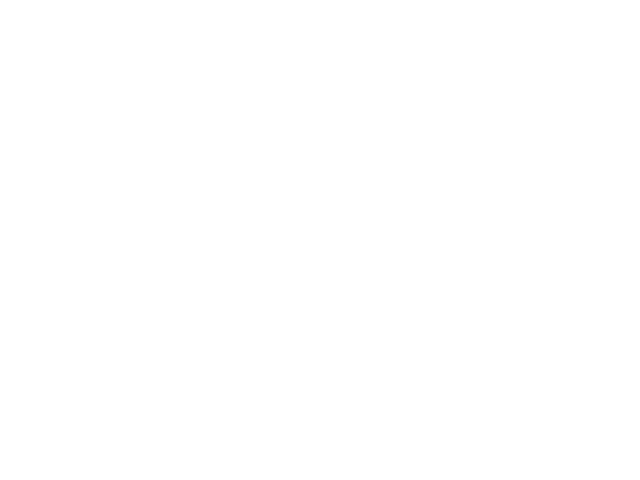

<IPython.core.display.Javascript object>


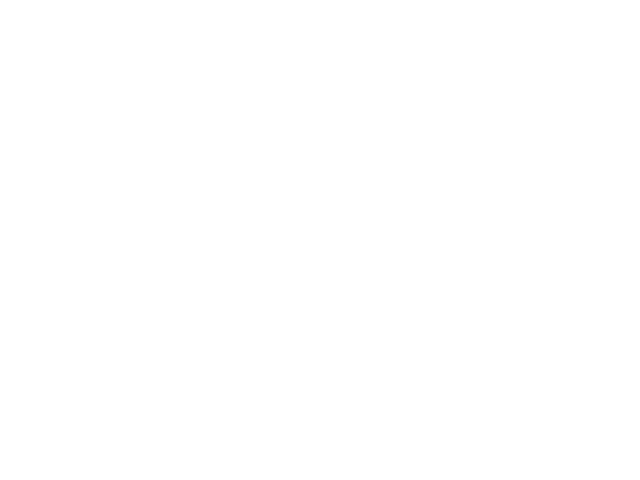

<IPython.core.display.Javascript object>


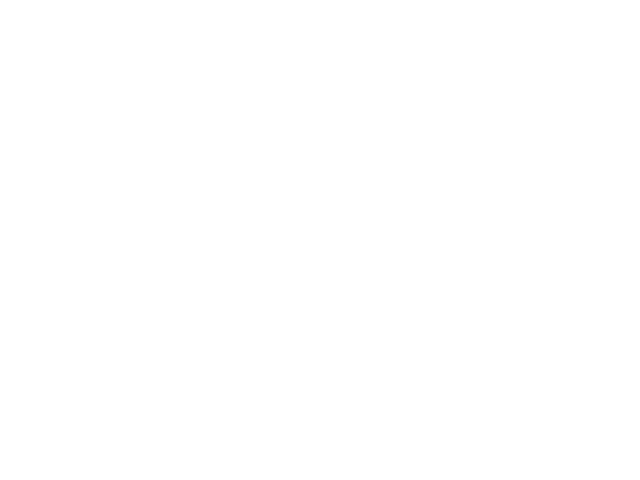

<IPython.core.display.Javascript object>


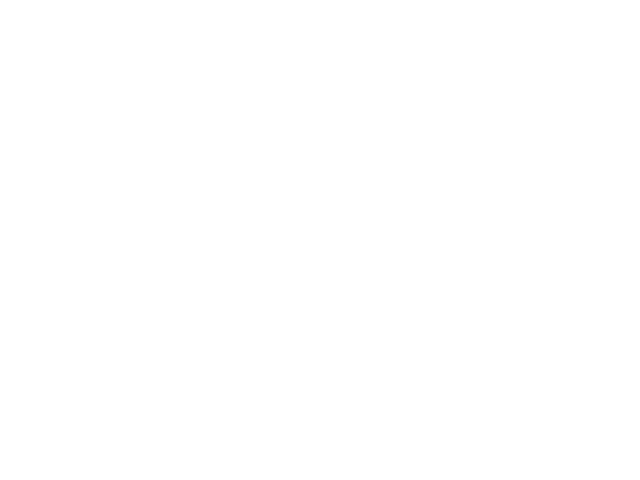

<IPython.core.display.Javascript object>


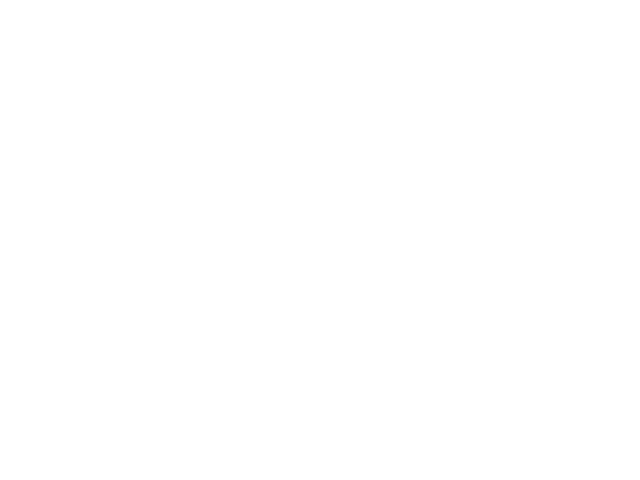

<IPython.core.display.Javascript object>


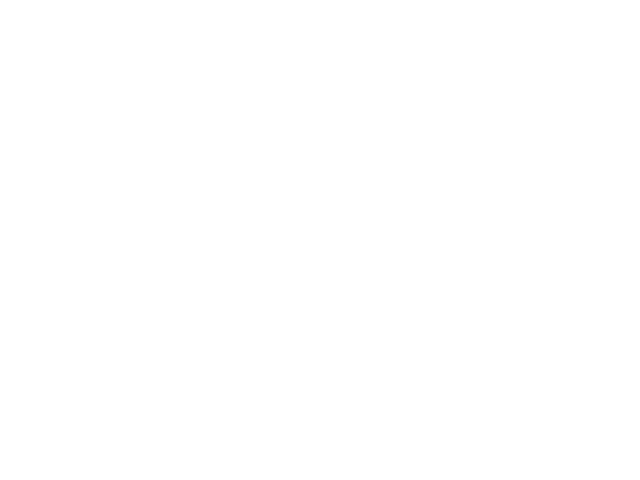

In [68]:
print_multipage(t,resp[lkat],plotZs,'fig_responsive')

In [25]:
peakinds = np.argmax(sfi.gaussian_filter(resp[:,4],sigma=(0,0,0,2)).mean(1).mean(1),axis=1)
order_by_peak = np.argsort(peakinds)
peaksort = peakinds[order_by_peak]

In [26]:
isresponsive = fig_responsive = (resp[:,1:5].mean(1).mean(1).mean(1)-resp[:,1:5].mean(1).mean(1).std(1)/np.sqrt(160)).max(1)>2*(resp[:,0].mean(1).mean(1)+resp[:,0].mean(1).std(1)/np.sqrt(40)).max(1)

In [27]:
isresponsive.sum()

37

In [28]:
avgresp = resp[:,1:4].mean(1).mean(1).mean(1)

<IPython.core.display.Javascript object>


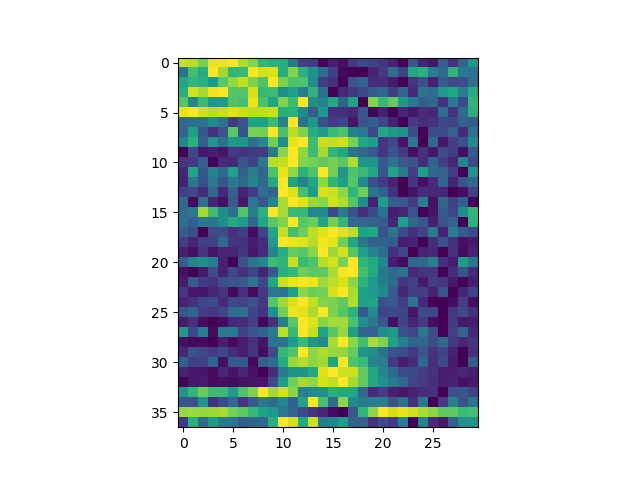

In [29]:
plt.imshow(norm01(avgresp[order_by_peak[isresponsive]]),interpolation='nearest',cmap=plt.cm.viridis)

In [30]:
ontarget = resp[lkat].mean(-1)
ontarget = ontarget[:,1:]-ontarget[:,0:1]

In [31]:
gd = np.where(isresponsive)[0]

In [32]:
tracez = (traces-traces.mean(1)[:,np.newaxis])/traces.std(1)[:,np.newaxis]

In [33]:
np.outer(isresponsive,paramdict['cross']).shape

(79, 200)

In [37]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
mx = np.maximum(Ccross.max(),Cfig.max())
mn = np.maximum(Ccross.min(),Cfig.min())

<IPython.core.display.Javascript object>


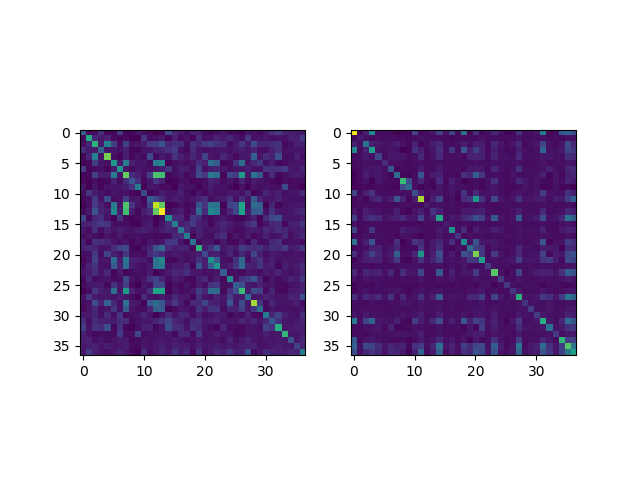

In [40]:
plt.subplot(1,2,1)
plt.imshow(Ccross,vmax=mx,vmin=mn)
# plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Cfig,vmax=mx,vmin=mn)
# plt.colorbar()

In [351]:
Ccross = np.cov(zs[isresponsive][:,paramdict['cross']].reshape((isresponsive.sum(),-1)))
Cfig = np.cov(zs[isresponsive][:,paramdict['fig']].reshape((isresponsive.sum(),-1)))
Cgrnd = np.cov(zs[isresponsive][:,paramdict['grnd']].reshape((isresponsive.sum(),-1)))
Ciso = np.cov(zs[isresponsive][:,paramdict['iso']].reshape((isresponsive.sum(),-1)))
ucross,scross,vcross = np.linalg.svd(Ccross)
ufig,sfig,vfig = np.linalg.svd(Cfig)
ugrnd,sgrnd,vgrnd = np.linalg.svd(Cgrnd)
uiso,siso,viso = np.linalg.svd(Ciso)

In [391]:
popvec = resp[isresponsive].mean(4)
popvec = popvec = popvec/np.linalg.norm(popvec,axis=0)

<IPython.core.display.Javascript object>


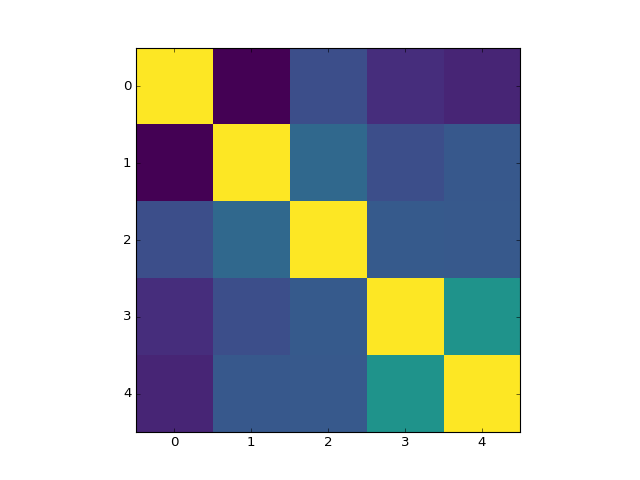

In [414]:
j = 4
k = 6
plt.imshow(np.dot(popvec[:,j,k,:].T,popvec[:,j,k,:]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)

<IPython.core.display.Javascript object>


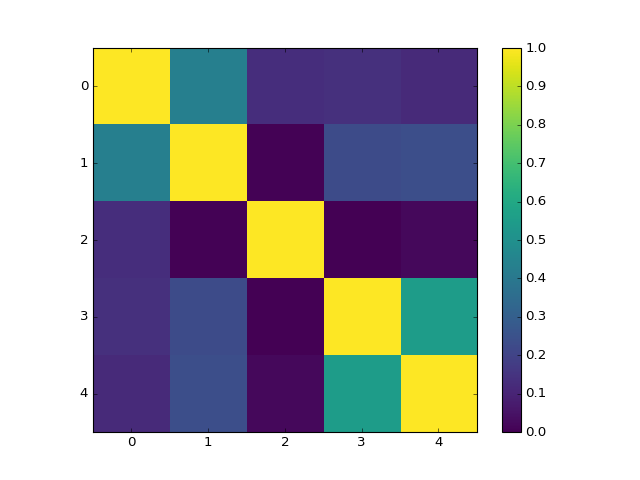

In [389]:
plt.imshow(np.abs(D[:20,:20]),interpolation='nearest',cmap=plt.cm.viridis,vmax=1)
plt.colorbar()

<IPython.core.display.Javascript object>


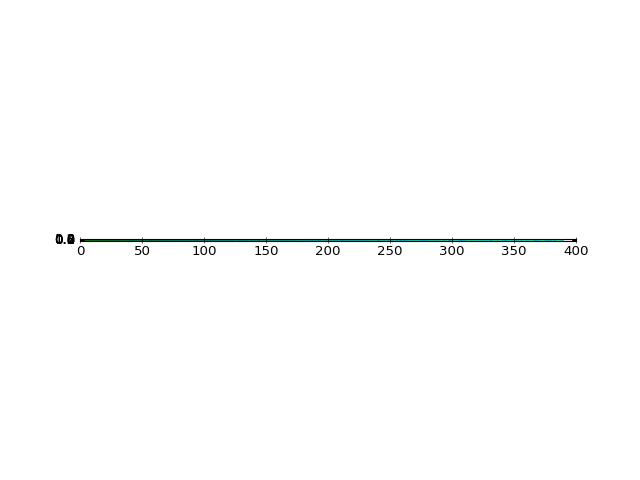

In [332]:
plt.plot(np.cumsum(scross/scross.sum()))
plt.plot(np.cumsum(sfig/sfig.sum()))

<IPython.core.display.Javascript object>


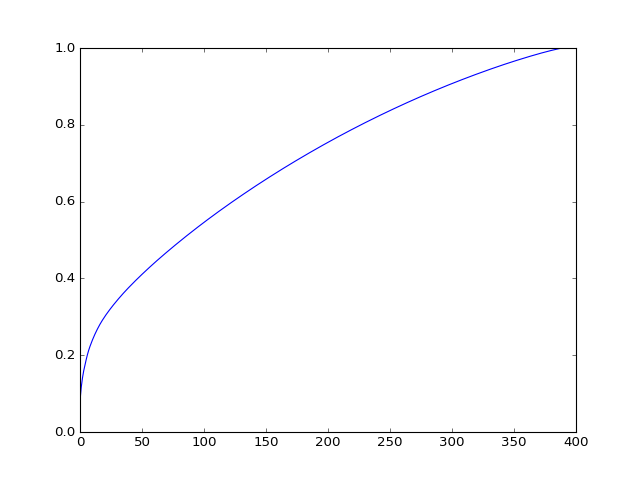

In [313]:
plt.plot(np.cumsum(s/s.sum()))

In [245]:
lincross = ontarget[:,0]+ontarget[:,1]
cross = ontarget[:,3]
liniso = ontarget[:,0]+ontarget[:,1,np.append(np.arange(6,8),np.arange(0,6))]
iso = ontarget[:,2]

<IPython.core.display.Javascript object>


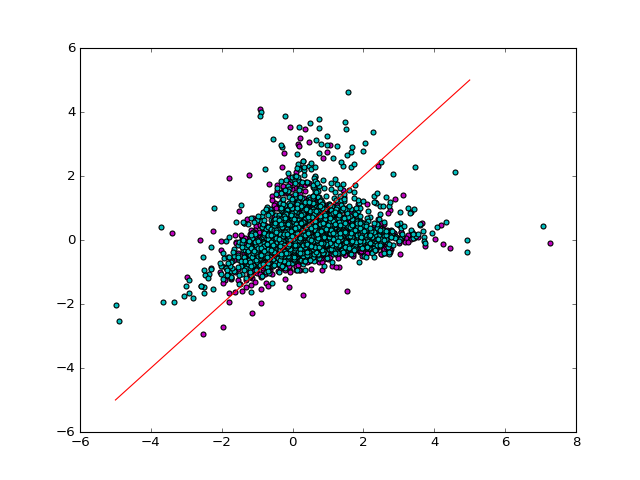

In [252]:
plt.scatter(liniso.flatten(),iso.flatten(),c='m')
plt.scatter(lincross.flatten(),cross.flatten(),c='c')
plt.plot((-5,5),(-5,5),c='r')

<IPython.core.display.Javascript object>


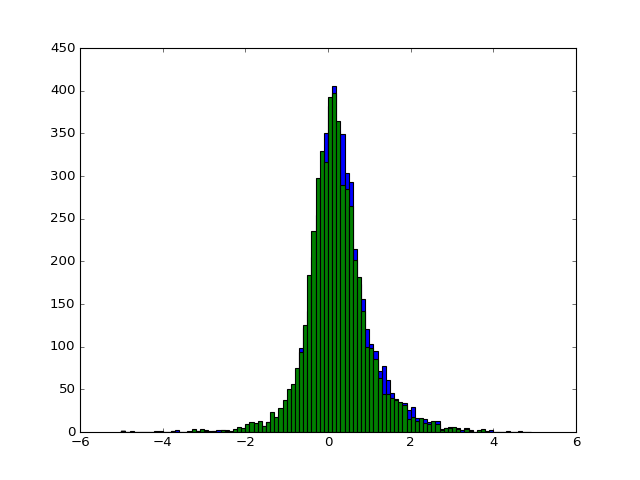

In [284]:
hiso = plt.hist(liniso.flatten()-iso.flatten(),bins=np.arange(-5,5,0.1))
hcross = plt.hist(lincross.flatten()-cross.flatten(),bins=np.arange(-5,5,0.1))

<IPython.core.display.Javascript object>


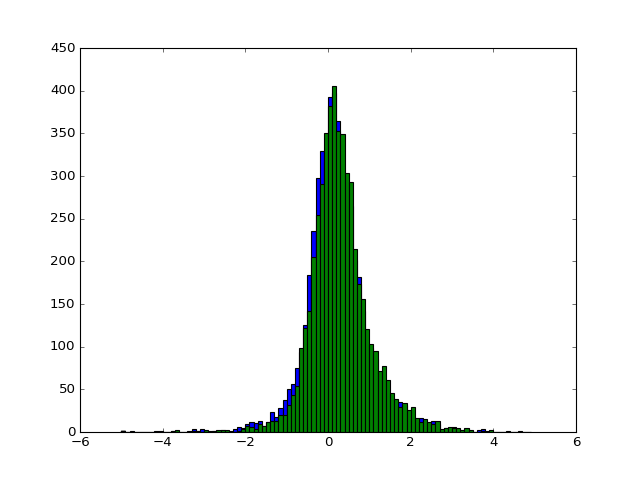

In [278]:
hiso[0].shape

(99,)

In [279]:
np.arange(-5,5,0.1).shape

(100,)